In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import random
random.seed(109)

import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

from sklearn.impute import KNNImputer

2023-03-15 17:43:10.657862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# measure notebook runtime
time_start = time.time()

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.



</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
# your code here 

df_flights = pd.read_csv("data/flights.csv")

In [6]:
# your code here

# Define a lambda function that takes a value and returns 1 if it is greater than or equal to 15, 0 otherwise
delay = lambda x: 1 if x >= 15 else 0

# Create a new column in the DataFrame called 'DELAY_OR_NOT' that maps the 'ARRIVAL_DELAY' column through the delay function
df_flights['DELAY_OR_NOT'] = df_flights['ARRIVAL_DELAY'].map(delay)

# Drop the 'ARRIVAL_DELAY' column from the DataFrame
df_flights = df_flights.drop('ARRIVAL_DELAY', axis=1)

In [7]:
grader.check("q1.1.1")

q1.1.1 results: All test cases passed!

<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

We believe using KNNImputer may be a better alternative than dropping the rows to fill in the missing values as it is more interesting here to fill in these missing values using other features in the dataset rather than dropping them altogether. Also, it is particularly useful in cases where the missing data is in multiple features at once. 

This enables us to preserve the integrity and completeness of the original dataset, and it works very well in combination with other preprocessing techniques such as scaling, which we also use.  

In [8]:
# your code here

print(df_flights.isna().sum())

DISTANCE               5
SCHEDULED_TIME         1
MONTH                  0
SCHED_DEP_HOUR         0
SCHED_ARR_HOUR         0
FLIGHT_COUNT           5
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DELAY_OR_NOT           0
dtype: int64


In [9]:
# select rows with missing values
rows_with_missing_values = df_flights[df_flights.isnull().any(axis=1)]

# print the selected rows
print(rows_with_missing_values)

      DISTANCE  SCHEDULED_TIME  MONTH  SCHED_DEP_HOUR  SCHED_ARR_HOUR  \
70         NaN           395.0     11               6               9   
1566       NaN           418.0      2               6               9   
3741       NaN           419.0     11              11              15   
5612       NaN           381.0      6               8              12   
6375       NaN             NaN      7              18              21   

      FLIGHT_COUNT  DAY_OF_WEEK ORIGIN_AIRPORT DESTINATION_AIRPORT  \
70             NaN            1            BOS                 SFO   
1566           NaN            5            BOS                 SFO   
3741           NaN            2            BOS                 SFO   
5612           NaN            5            BOS                 SFO   
6375           NaN            3            BOS                 SFO   

      DELAY_OR_NOT  
70               0  
1566             0  
3741             0  
5612             0  
6375             1  


In [10]:
# one hot encode the categorical variable
df_flights = pd.get_dummies(df_flights, columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

In [11]:
# create KNNImputer object and fit to data
imputer = KNNImputer(n_neighbors=2)
imputer.fit(df_flights)

# transform data with imputed values
df_flights = pd.DataFrame(imputer.transform(df_flights), columns=df_flights.columns)

In [12]:
# We check which types our columns have
# Need to OHE 'ORIGIN_AIRPORT' and 'DESTINATION_AIRPORT'

df_flights.dtypes

DISTANCE                   float64
SCHEDULED_TIME             float64
MONTH                      float64
SCHED_DEP_HOUR             float64
SCHED_ARR_HOUR             float64
                            ...   
DESTINATION_AIRPORT_VLD    float64
DESTINATION_AIRPORT_VPS    float64
DESTINATION_AIRPORT_XNA    float64
DESTINATION_AIRPORT_YAK    float64
DESTINATION_AIRPORT_YUM    float64
Length: 811, dtype: object

In [13]:
# train test split
# Split the dataset into training and test sets
y = df_flights['DELAY_OR_NOT']
X = df_flights.drop('DELAY_OR_NOT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=109)

# Scale the features using StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # fit on the training set
X_train = scaler.transform(X_train) # scale the training set
X_test = scaler.transform(X_test) # scale the test set

# Convert the scaled numpy arrays back into dataframes
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Keep the feature labels
predictors = list(X.columns)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("X_test shape:", y_test.shape)


X_train shape: (8000, 810)
y_train shape: (8000,)
X_test shape: (2000, 810)
X_test shape: (2000,)


<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs. Feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>



</div>

In [14]:
# set the number of hidden layers
n_hidden = 2

# set the size of each hidden layer
hidden_size = 15

# set the batch size
batch_size = 128

# create a sequential model
NN_model = tf.keras.Sequential()

# add an input layer with the same shape as X_train
NN_model.add(tf.keras.Input(shape=X_train.shape[1]))

# add n_hidden number of hidden layers
for i in range(n_hidden):
    NN_model.add(tf.keras.layers.Dense(hidden_size, activation='relu'))

# add an output layer with sigmoid activation
NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


2023-03-15 17:43:17.737461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                12165     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________


In [16]:
# compile NN
NN_model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

In [17]:
# fit the model to the training data
history = NN_model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
200/200 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5808 - val_loss: 0.6454 - val_accuracy: 0.6181
Epoch 2/6
200/200 [==============================] - 0s 1ms/step - loss: 0.5853 - accuracy: 0.6961 - val_loss: 0.6047 - val_accuracy: 0.6781
Epoch 3/6
200/200 [==============================] - 0s 1ms/step - loss: 0.5238 - accuracy: 0.7434 - val_loss: 0.6080 - val_accuracy: 0.6894
Epoch 4/6
200/200 [==============================] - 0s 1ms/step - loss: 0.4932 - accuracy: 0.7609 - val_loss: 0.6153 - val_accuracy: 0.6938
Epoch 5/6
200/200 [==============================] - 0s 1ms/step - loss: 0.4732 - accuracy: 0.7756 - val_loss: 0.6357 - val_accuracy: 0.6975
Epoch 6/6
200/200 [==============================] - 0s 1ms/step - loss: 0.4589 - accuracy: 0.7789 - val_loss: 0.6376 - val_accuracy: 0.7119


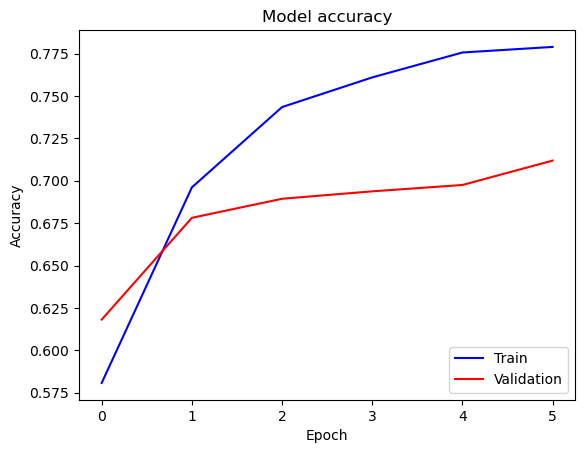

In [18]:
# plot the training and validation accuracy as a function of epochs
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [19]:
# evaluate the model on the training data
train_loss, train_accuracy = NN_model.evaluate(X_train, y_train)
print('Train accuracy:', train_accuracy)

# evaluate the model on the test data
test_loss, test_accuracy = NN_model.evaluate(X_test, y_test)
print('Test accuracy:', test_accuracy)

250/250 [==============================] - 0s 726us/step - loss: 0.4687 - accuracy: 0.7860
Train accuracy: 0.7860000133514404
63/63 [==============================] - 0s 855us/step - loss: 0.6840 - accuracy: 0.6975
Test accuracy: 0.6974999904632568


<div class='exercise-r'>

**1.3**  **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second, "proxy" model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.




</div>

<div class='exercise-r'>

**1.3.1**  First, generate a set of `NN_model` class predictions for the training set. Call these `y_train_nn`. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.




</div>

In [20]:
# Predict binary labels on train set using neural network model
# Threshold probabilities at 0.5 to obtain binary labels
y_train_nn = (NN_model.predict(X_train) > 0.5).astype("int32")


250/250 [==============================] - 0s 637us/step


In [21]:
grader.check("q1.3.1")

q1.3.1 results: All test cases passed!

<div class='exercise-r'>

**1.3.2**  Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Next, print the `logreg` test accuracy compared to the *true $y$ values* to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.




</div>

In [22]:
# your code here

# Create a logistic regression model with L2 penalty
logreg = LogisticRegression(penalty='l2', C=0.2, max_iter=1000)

# Fit the logistic regression model to the training data
logreg.fit(X_train, y_train_nn.ravel())

print("Logistic regression Test Accuracy: {:.2f}%".format(logreg.score(X_test, y_test)*100))
print("Previous Test Accuracy: {:.2f}%".format(test_accuracy*100))

Logistic regression Test Accuracy: 70.50%
Previous Test Accuracy: 69.75%


<div class='exercise-r'>

**1.3.3**  Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>



</div>

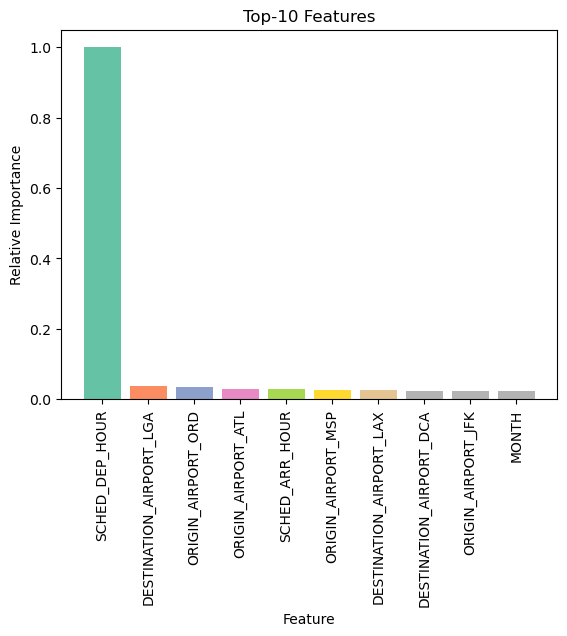

CPU times: user 3.56 s, sys: 554 ms, total: 4.12 s
Wall time: 51.5 s


In [23]:
%%time

# Compute permutation-based feature importances
result = permutation_importance(logreg, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                random_state=0, 
                                n_jobs=-1)

importances = result.importances_mean

# Find indices of top-10 features
top_n = 10
idx = np.argsort(importances)[::-1][:top_n]

# Normalize importances and create color map
norm_imp = importances / importances.max()
colors = plt.cm.Set2(np.arange(top_n))

# Create bar plot with different colors for top features
plt.bar(range(top_n), norm_imp[idx], color=colors)
plt.xticks(range(top_n), X_train.columns[idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.title('Top-10 Features')
plt.show()

<div class='exercise-r'>

**1.4**  **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.




</div>

<div class='exercise-r'>

**1.4.1**
    
Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical.
    
Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

**NOTE:** Again, the values of `SCHED_DEP_HOUR` used her for predictions and plotting should be those actually *observed* in the training data.


</div>

The plot above indicates that the probability of delay increases in a nearly linear manner as the scheduled departure hour advances. This finding supports the previous plot, which emphasized the significance of this predictor over others. Moreover, the observation aligns with the intuition that departure hour is a key factor influencing delays.

In [24]:
# List of relevant predictors
relevant_predictors = ['SCHED_DEP_HOUR']

# List of continuous predictors
continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH', 'SCHED_ARR_HOUR', 'FLIGHT_COUNT', 'DAY_OF_WEEK']

# List of categorical predictors
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

# Create a copy of the training dataset
X_temp = X_train.copy()

# Iterate through each column in the dataset
for col in X_temp.columns:
    
    # If the column is continuous, set the value to the mean
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
        
    # If the column is categorical, set the value to the mode
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()

# Inverse transform the scaled dataset to the original unscaled data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)


250/250 [==============================] - 0s 667us/step


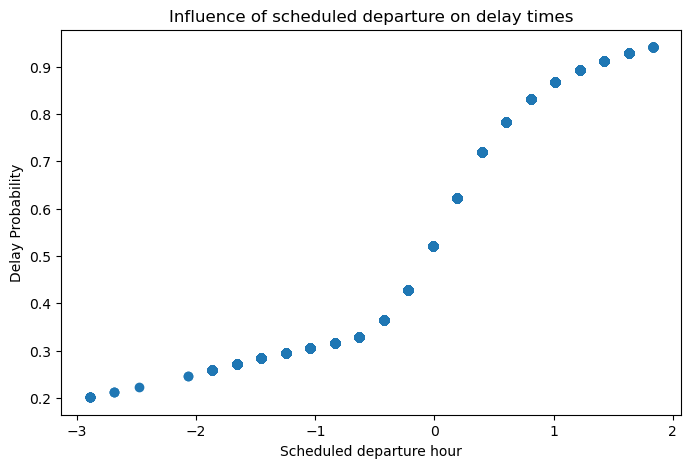

In [25]:
# prediction

delay_prob = NN_model.predict(X_temp)


plt.figure(figsize=(8, 5))
plt.scatter(X_temp['SCHED_DEP_HOUR'], delay_prob)
plt.title('Influence of scheduled departure on delay times')
plt.xlabel('Scheduled departure hour')
plt.ylabel('Delay Probability')
plt.show()

<div class='exercise-r'>

**1.4.2**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values `SCHED_DEP_HOUR` and `FLIGHT_COUNT` observed in the training set.  
    
**NOTE:** See hint in 1.4.5 about plotting in this section




</div>

In [26]:
# Define relevant, continuous, and categorical predictors
relevant_predictors = ['SCHED_DEP_HOUR', 'FLIGHT_COUNT']
continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH','SCHED_ARR_HOUR', 'DAY_OF_WEEK']
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

# Create a copy of the training data to modify
X_temp = X_train.copy()

# Fill continuous predictors with mean values and categorical predictors with mode values
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscale modified training data and store as DataFrame
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 646us/step


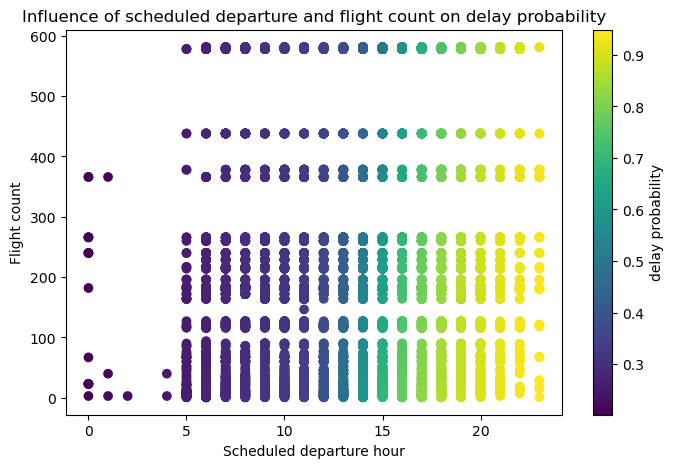

In [27]:
# your code here

# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['FLIGHT_COUNT'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Flight count')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()



<div class='exercise-r'>

**1.4.3**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` observed in the training set.




</div>

In [28]:
relevant_predictors = ['SCHED_DEP_HOUR', 'SCHED_ARR_HOUR']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 'MONTH','FLIGHT_COUNT', 'DAY_OF_WEEK']

# Extracting categorical predictors by subtracting continuous predictors and relevant predictors from all predictors
categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

# Mean imputation for continuous predictors and mode imputation for categorical predictors
for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Convert the imputed and scaled data back to unscaled data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 670us/step


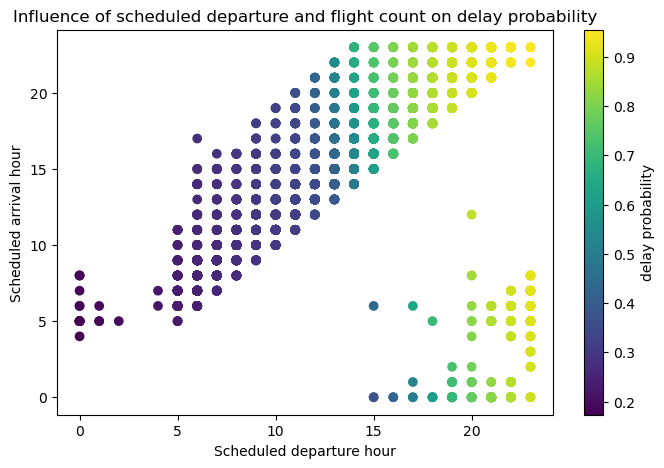

In [29]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['SCHED_ARR_HOUR'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Scheduled arrival hour')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.4**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `DISTANCE` observed in the training set. 




</div>

In [30]:
# your code here

relevant_predictors = ['SCHED_DEP_HOUR', 'DISTANCE']

continuous_pred = ['SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK', 'FLIGHT_COUNT']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 651us/step


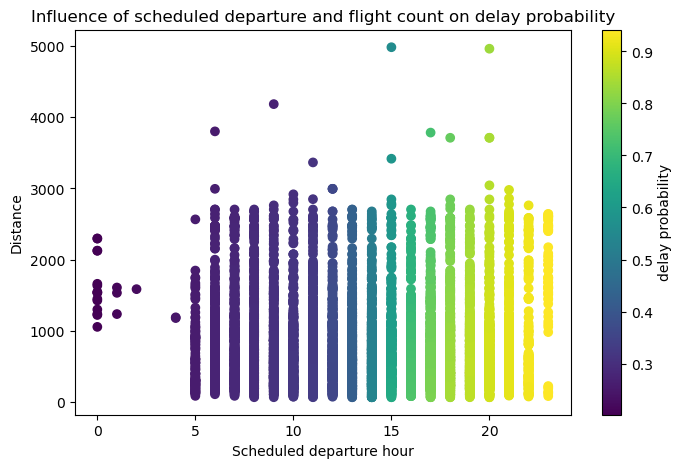

In [31]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['DISTANCE'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Distance')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.5**  In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>



</div>

In 1.4.2, the probability of delay is observed to increase as both the flight count and scheduled departure hour increase. However, the scheduled departure hour remains a more significant factor, as the range of variability in probability for a fixed hour is not substantial. Additionally, at large scheduled departure hours, the flight count appears to have no effect, and all probabilities of delay remain high. 

In 1.4.3, the impact of scheduled arrival hour on probability is found to be higher than that of flight count. The probability increases as the scheduled arrival hour surpasses the scheduled departure hour, which is intuitive. However, this increase in probability is not consistent across all scheduled departure hours, with later hours exhibiting a higher range of delay probabilities for scheduled arrival hours. 

Finally, 1.4.4 reveals that distance has minimal influence on the delay probability. Although a few data points indicate a low delay probability for short distances and high probability for long distances, there are no clear trends.

<div class='exercise-r'>

**1.5**  **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>



</div>

In [32]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

Upon examining the prediction probabilities of the neural network model for a given datapoint, we observed that the distribution did not follow the typical normal distribution pattern as commonly observed in regression models. Instead, we noticed a concentration of probabilities around the upper and lower bounds of the 95% confidence interval. This phenomenon might be attributed to the inherent complexity of neural networks, which tend to overfit easily without the application of regularization techniques such as dropout. Overfitting occurs when the model is too closely fit to the training data, leading to poor generalization to new data. Therefore, it is crucial to implement suitable regularization methods to prevent overfitting and improve the generalization ability of the neural network model.

In [33]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here

# NN model for bootstrap
n_bootstrap = 75

# list to store bootstrap predictions
bootstrap_preds = []

# loop over bootstrap samples
for k in range(n_bootstrap):
    progressbar(k, n_bootstrap)
    
    # build NN
    NN_boot = tf.keras.Sequential()
    for i in range(n_hidden):
        NN_boot.add(tf.keras.layers.Dense(hidden_size, activation='sigmoid'))
    NN_boot.add(tf.keras.layers.Dense(1, activation='relu'))
    
    # sample from training data with replacement
    sample_idx = np.random.choice(X_train.index, size=len(X_train.index), replace=True)
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # compile and fit the model
    NN_boot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    NN_boot.fit(X_sample, y_sample, batch_size=32, epochs=10, validation_split=0.2, verbose=0)
    
    # make predictions on the test set and store the predictions in the bootstrap_preds list
    y_sample_pred = NN_boot.predict(X_test)
    bootstrap_preds.append(y_sample_pred)

63/63 [==============================] - 0s 832us/step74
 [==================================================] 75/75 Done...

63/63 [==============================] - 0s 734us/step
CPU times: user 4min 41s, sys: 28.6 s, total: 5min 10s
Wall time: 4min 4s


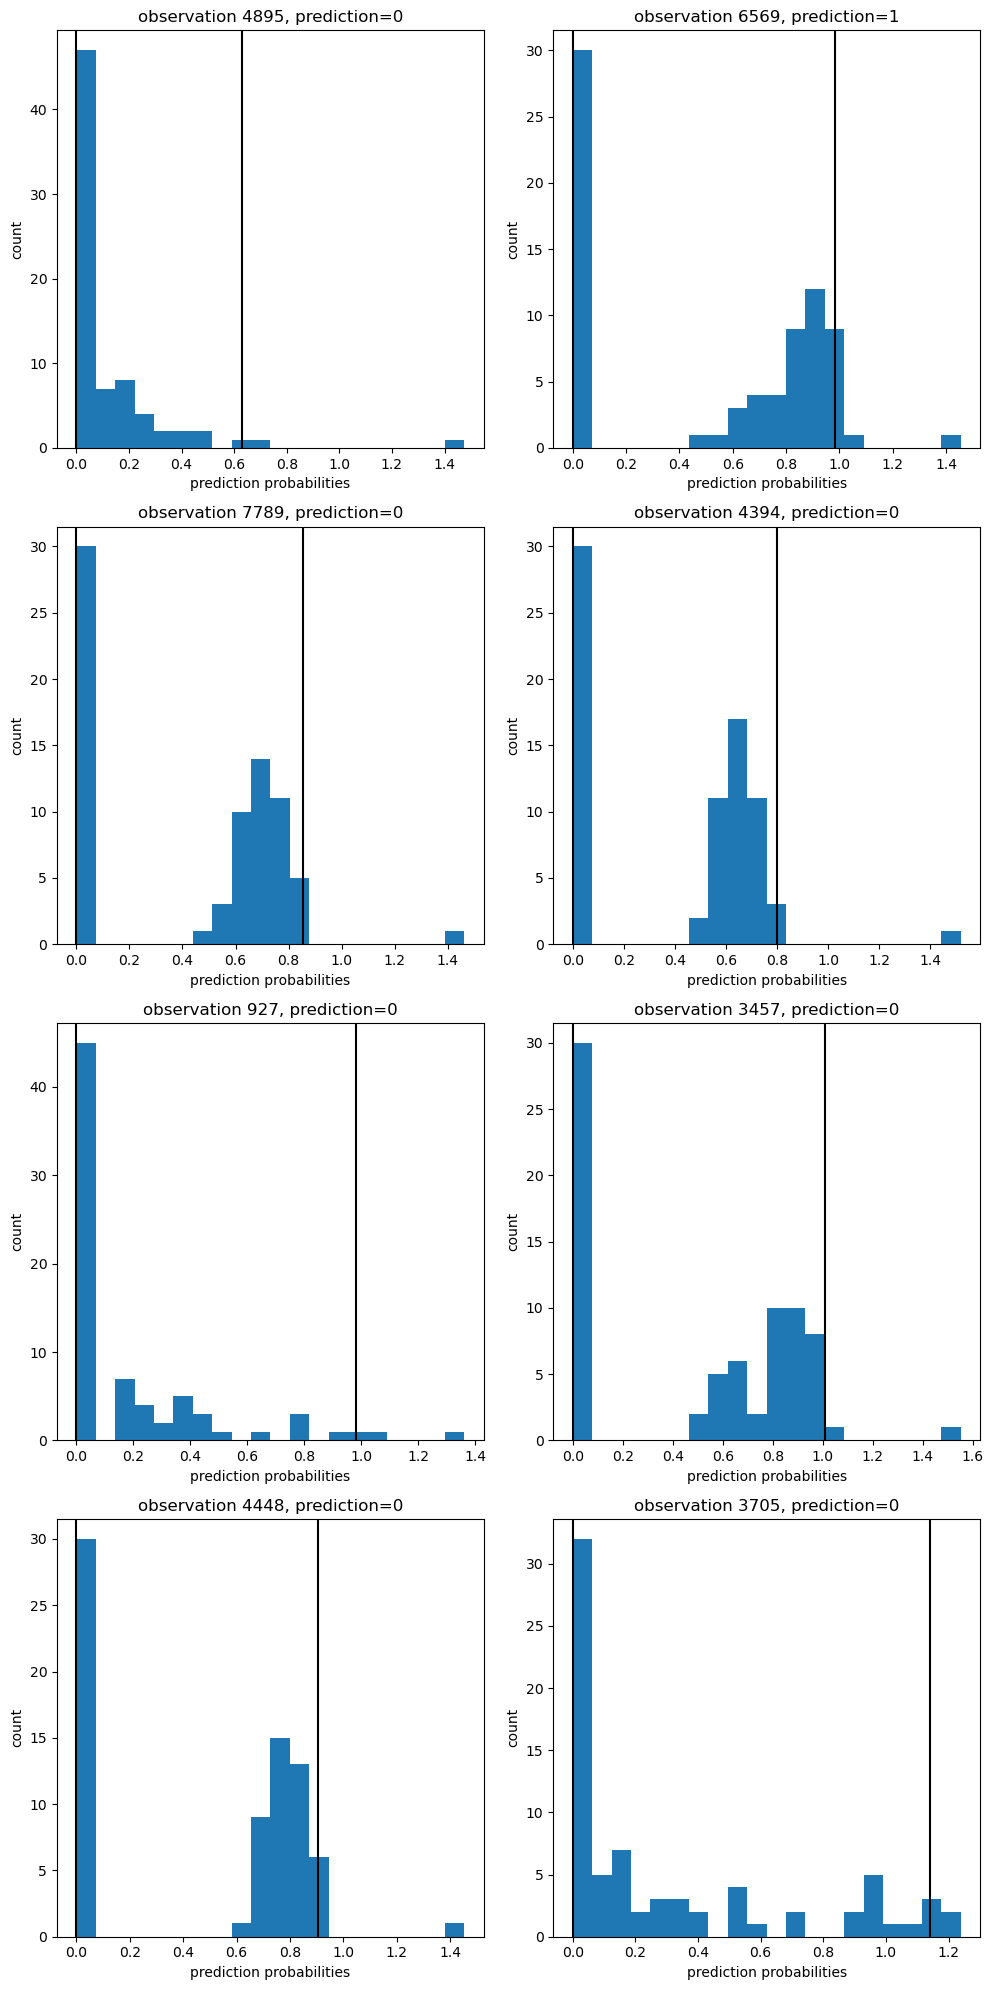

In [34]:
# Reshape bootstrap predictions
bootstrap_preds = np.array(bootstrap_preds).reshape(n_bootstrap, X_test.shape[0])

# Generate random observations for plotting
obs = [np.random.randint(X_train.shape[0]) for i in range(8)]

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
axs = axs.flatten()

# Iterate over observations
for i, o in enumerate(obs):
    # Get bootstrap predictions for the observation
    obs_pred = bootstrap_preds[:, i]
    
    # Calculate prediction based on bootstrap mean
    res = 1*(np.mean(obs_pred)>0.5)
    
    # Plot histogram of prediction probabilities
    axs[i].hist(obs_pred, bins=20)
    
    # Add vertical lines for confidence intervals
    axs[i].axvline(np.quantile(obs_pred, 0.025), color='black')
    axs[i].axvline(np.quantile(obs_pred, 0.975), color='black')
    
    # Set axis labels and title
    axs[i].set_xlabel("prediction probabilities")
    axs[i].set_ylabel("count")
    axs[i].set_title("observation {}, prediction={}".format(o, res))

# Adjust layout and display plot
plt.tight_layout()
plt.show()


<div class='exercise-r'>

**1.6**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

Upon analysis, we observe that the test accuracy for the bagging model has improved compared to previous results. However, the new model that incorporates the technique of abstaining does not appear to be very effective in this context. We notice that as the threshold for abstaining increases, the proportion of test observations that are not abstained also decreases, but this is accompanied by a decline in accuracy. This could potentially be attributed to the fact that our previous findings revealed that the various bootstrapped predictions for a given observation were not distributed normally.

In [35]:
y_test_pred = (NN_model.predict(X_test) > 0.5).astype("int32")
y_test_pred = np.argmax(y_test_pred, axis=1)

63/63 [==============================] - 0s 784us/step


Test bagging accuracy: 0.859


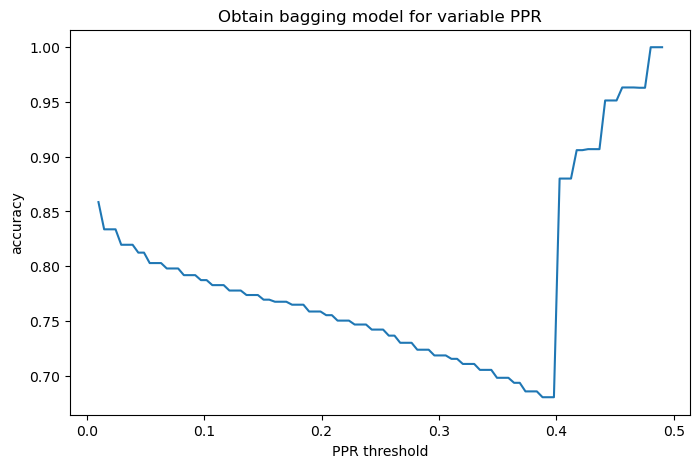

In [36]:
# your code here

# Calculate the number of times each observation was predicted as the negative class
v0 = np.sum(bootstrap_preds<0.5, axis=0)
# Calculate the number of times each observation was predicted as the positive class
v1 = n_bootstrap - v0
# Stack v0 and v1 into a 2D array
v = np.stack((v0, v1))
# Calculate the per point relative frequency of choosing the minority class for each observation
PPR = np.min(v, axis=0)/n_bootstrap

# Obtain bagging predictions by taking the mean of all bootstrap predictions and thresholding at 0.5
bagg_pred = 1*(np.mean(bootstrap_preds, axis=0)>0.5)
# Calculate accuracy of bagging predictions
bagg_acc = accuracy_score(y_test_pred, bagg_pred)

# Flatten y_test_pred
y_test_pred = y_test_pred.flatten()
# Obtain predictions by taking the mean of all bootstrap predictions and thresholding at 0.5
pred = 1*(np.mean(bootstrap_preds, axis=0)>0.5)

# Print the accuracy of bagging predictions
print("Test bagging accuracy: {:.3f}".format(bagg_acc))

# Generate a sequence of thresholds to test
thresh = np.linspace(0.01, .49, 100)
kept = []
abs_bagg_acc = []

# For each threshold, keep all observations whose PPR is above the threshold, 
# and calculate the accuracy of the resulting predictions
for t in thresh:
    to_keep = PPR>t
    kept.append(np.sum(to_keep))
    acc = accuracy_score(y_test_pred[to_keep], pred[to_keep])
    abs_bagg_acc.append(acc)

# Plot the accuracy of predictions obtained by keeping observations with PPR above each threshold
plt.figure(figsize=(8, 5))
plt.plot(thresh, abs_bagg_acc)
plt.xlabel("PPR threshold")
plt.ylabel("accuracy")
plt.title("Obtain bagging model for variable PPR")
plt.show()

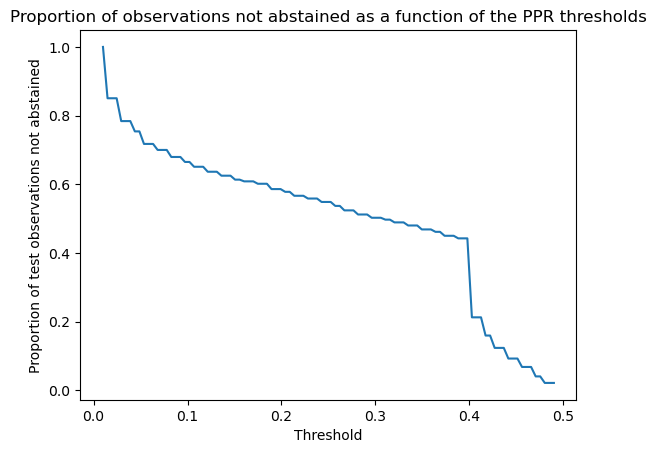

In [37]:
# your code here
plt.plot(thresh,np.array(kept)/len(y_test))
plt.xlabel("Threshold")
plt.ylabel("Proportion of test observations not abstained")
plt.title("Proportion of observations not abstained as a function of the PPR thresholds")
plt.show()

In [38]:
# your code here
...

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


Artificial neural networks (ANNs) can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3.1](#q2.3.1).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

<a id="q22"></a>



</div>

In [39]:
# your code here
df_train = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_train.csv")
df_test = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_test.csv")

In [40]:
# your code here
x_train, y_train = df_train.drop(["output"],axis=1), df_train["output"]
x_test = df_test

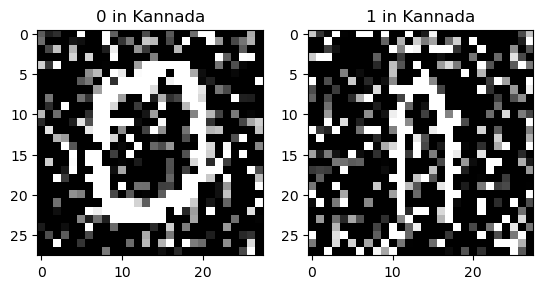

In [41]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(x_train.loc[2].values,(28,28)),cmap="gray")
ax[0].set_title("0 in Kannada")
ax[1].imshow(np.reshape(x_train.loc[0].values,(28,28)),cmap="gray")
ax[1].set_title("1 in Kannada")
plt.show()

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 




</div>

**Answer to Q2.2**

One can observe that the model is overfitting when the training accuracy reaches 100% and stops changing after just a few epochs. Additionally, the validation accuracy remains relatively low and remains nearly constant after approximately 300 epochs.

In [42]:
# your code here
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_overfit = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
model_overfit.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [43]:
%%time 
# your code here
epochs = 1000
history=model_overfit.fit(x_train, y_train, epochs=epochs,
                          batch_size=128,
                          validation_split=0.3)

Epoch 1/1000
7/7 [==============================] - 1s 25ms/step - loss: 11.4580 - accuracy: 0.5250 - val_loss: 4.1219 - val_accuracy: 0.5333
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.1040 - accuracy: 0.5476 - val_loss: 1.3014 - val_accuracy: 0.6361
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3224 - accuracy: 0.6274 - val_loss: 1.0189 - val_accuracy: 0.6556
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.7987 - accuracy: 0.7060 - val_loss: 0.8461 - val_accuracy: 0.7028
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.6232 - accuracy: 0.7393 - val_loss: 0.6116 - val_accuracy: 0.7722
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4860 - accuracy: 0.7845 - val_loss: 0.5511 - val_accuracy: 0.7750
Epoch 7/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.3808 - accuracy: 0.8250 - val_loss: 0.4874 - val_accuracy: 0.8111
Epoch 8/1000
7/7 [

7/7 [==============================] - 0s 6ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.4436 - val_accuracy: 0.8917
Epoch 60/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4449 - val_accuracy: 0.8917
Epoch 61/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.4480 - val_accuracy: 0.8917
Epoch 62/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.4530 - val_accuracy: 0.8917
Epoch 63/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.4547 - val_accuracy: 0.8917
Epoch 64/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4572 - val_accuracy: 0.8917
Epoch 65/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4607 - val_accuracy: 0.8917
Epoch 66/1000
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 3.9984e-04 - accuracy: 1.0000 - val_loss: 0.5571 - val_accuracy: 0.8972
Epoch 117/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.9070e-04 - accuracy: 1.0000 - val_loss: 0.5663 - val_accuracy: 0.8972
Epoch 118/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.8048e-04 - accuracy: 1.0000 - val_loss: 0.5643 - val_accuracy: 0.8972
Epoch 119/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.7060e-04 - accuracy: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.8972
Epoch 120/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.6612e-04 - accuracy: 1.0000 - val_loss: 0.5693 - val_accuracy: 0.8972
Epoch 121/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.5352e-04 - accuracy: 1.0000 - val_loss: 0.5707 - val_accuracy: 0.8972
Epoch 122/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4751e-04 - accuracy: 1.0000 - val_loss: 0.5724 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.4732e-04 - accuracy: 1.0000 - val_loss: 0.6286 - val_accuracy: 0.8972
Epoch 173/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4550e-04 - accuracy: 1.0000 - val_loss: 0.6302 - val_accuracy: 0.8972
Epoch 174/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4362e-04 - accuracy: 1.0000 - val_loss: 0.6286 - val_accuracy: 0.8972
Epoch 175/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4161e-04 - accuracy: 1.0000 - val_loss: 0.6319 - val_accuracy: 0.8972
Epoch 176/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4055e-04 - accuracy: 1.0000 - val_loss: 0.6338 - val_accuracy: 0.8972
Epoch 177/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3844e-04 - accuracy: 1.0000 - val_loss: 0.6306 - val_accuracy: 0.8972
Epoch 178/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3631e-04 - accuracy: 1.0000 - val_loss: 0.6364 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 7.5922e-05 - accuracy: 1.0000 - val_loss: 0.6782 - val_accuracy: 0.8944
Epoch 229/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.5202e-05 - accuracy: 1.0000 - val_loss: 0.6790 - val_accuracy: 0.8944
Epoch 230/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.4383e-05 - accuracy: 1.0000 - val_loss: 0.6798 - val_accuracy: 0.8944
Epoch 231/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.3553e-05 - accuracy: 1.0000 - val_loss: 0.6796 - val_accuracy: 0.8944
Epoch 232/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.2924e-05 - accuracy: 1.0000 - val_loss: 0.6820 - val_accuracy: 0.8944
Epoch 233/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.2219e-05 - accuracy: 1.0000 - val_loss: 0.6804 - val_accuracy: 0.8917
Epoch 234/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.1729e-05 - accuracy: 1.0000 - val_loss: 0.6820 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 4.5706e-05 - accuracy: 1.0000 - val_loss: 0.7153 - val_accuracy: 0.8944
Epoch 285/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.5345e-05 - accuracy: 1.0000 - val_loss: 0.7162 - val_accuracy: 0.8944
Epoch 286/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.4940e-05 - accuracy: 1.0000 - val_loss: 0.7171 - val_accuracy: 0.8944
Epoch 287/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.4713e-05 - accuracy: 1.0000 - val_loss: 0.7175 - val_accuracy: 0.8944
Epoch 288/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.4223e-05 - accuracy: 1.0000 - val_loss: 0.7182 - val_accuracy: 0.8944
Epoch 289/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.3846e-05 - accuracy: 1.0000 - val_loss: 0.7186 - val_accuracy: 0.8944
Epoch 290/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.3559e-05 - accuracy: 1.0000 - val_loss: 0.7182 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 2.9863e-05 - accuracy: 1.0000 - val_loss: 0.7455 - val_accuracy: 0.8944
Epoch 341/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.9608e-05 - accuracy: 1.0000 - val_loss: 0.7491 - val_accuracy: 0.8917
Epoch 342/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.9428e-05 - accuracy: 1.0000 - val_loss: 0.7486 - val_accuracy: 0.8917
Epoch 343/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.9230e-05 - accuracy: 1.0000 - val_loss: 0.7475 - val_accuracy: 0.8917
Epoch 344/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8974e-05 - accuracy: 1.0000 - val_loss: 0.7504 - val_accuracy: 0.8944
Epoch 345/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8792e-05 - accuracy: 1.0000 - val_loss: 0.7518 - val_accuracy: 0.8944
Epoch 346/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.8631e-05 - accuracy: 1.0000 - val_loss: 0.7488 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.0071e-05 - accuracy: 1.0000 - val_loss: 0.7804 - val_accuracy: 0.8917
Epoch 397/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9952e-05 - accuracy: 1.0000 - val_loss: 0.7784 - val_accuracy: 0.8917
Epoch 398/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9804e-05 - accuracy: 1.0000 - val_loss: 0.7822 - val_accuracy: 0.8917
Epoch 399/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9598e-05 - accuracy: 1.0000 - val_loss: 0.7846 - val_accuracy: 0.8917
Epoch 400/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9584e-05 - accuracy: 1.0000 - val_loss: 0.7818 - val_accuracy: 0.8917
Epoch 401/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9357e-05 - accuracy: 1.0000 - val_loss: 0.7834 - val_accuracy: 0.8917
Epoch 402/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9201e-05 - accuracy: 1.0000 - val_loss: 0.7857 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.3688e-05 - accuracy: 1.0000 - val_loss: 0.8115 - val_accuracy: 0.8944
Epoch 453/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3597e-05 - accuracy: 1.0000 - val_loss: 0.8125 - val_accuracy: 0.8944
Epoch 454/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3526e-05 - accuracy: 1.0000 - val_loss: 0.8126 - val_accuracy: 0.8944
Epoch 455/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3449e-05 - accuracy: 1.0000 - val_loss: 0.8123 - val_accuracy: 0.8944
Epoch 456/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3359e-05 - accuracy: 1.0000 - val_loss: 0.8132 - val_accuracy: 0.8944
Epoch 457/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3278e-05 - accuracy: 1.0000 - val_loss: 0.8143 - val_accuracy: 0.8944
Epoch 458/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3189e-05 - accuracy: 1.0000 - val_loss: 0.8155 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 9.7844e-06 - accuracy: 1.0000 - val_loss: 0.8417 - val_accuracy: 0.8944
Epoch 509/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7873e-06 - accuracy: 1.0000 - val_loss: 0.8383 - val_accuracy: 0.8944
Epoch 510/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.7032e-06 - accuracy: 1.0000 - val_loss: 0.8385 - val_accuracy: 0.8944
Epoch 511/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.6386e-06 - accuracy: 1.0000 - val_loss: 0.8408 - val_accuracy: 0.8944
Epoch 512/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5918e-06 - accuracy: 1.0000 - val_loss: 0.8430 - val_accuracy: 0.8944
Epoch 513/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.5064e-06 - accuracy: 1.0000 - val_loss: 0.8391 - val_accuracy: 0.8944
Epoch 514/1000
7/7 [==============================] - 0s 6ms/step - loss: 9.4914e-06 - accuracy: 1.0000 - val_loss: 0.8399 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 7.0515e-06 - accuracy: 1.0000 - val_loss: 0.8720 - val_accuracy: 0.8972
Epoch 565/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.9372e-06 - accuracy: 1.0000 - val_loss: 0.8695 - val_accuracy: 0.8972
Epoch 566/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.8724e-06 - accuracy: 1.0000 - val_loss: 0.8725 - val_accuracy: 0.8972
Epoch 567/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.8211e-06 - accuracy: 1.0000 - val_loss: 0.8737 - val_accuracy: 0.8972
Epoch 568/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7550e-06 - accuracy: 1.0000 - val_loss: 0.8702 - val_accuracy: 0.8972
Epoch 569/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.7392e-06 - accuracy: 1.0000 - val_loss: 0.8698 - val_accuracy: 0.8972
Epoch 570/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.6620e-06 - accuracy: 1.0000 - val_loss: 0.8761 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 4.8058e-06 - accuracy: 1.0000 - val_loss: 0.9052 - val_accuracy: 0.8917
Epoch 621/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.7752e-06 - accuracy: 1.0000 - val_loss: 0.9037 - val_accuracy: 0.8917
Epoch 622/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.7562e-06 - accuracy: 1.0000 - val_loss: 0.9061 - val_accuracy: 0.8917
Epoch 623/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.7203e-06 - accuracy: 1.0000 - val_loss: 0.9068 - val_accuracy: 0.8917
Epoch 624/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.6860e-06 - accuracy: 1.0000 - val_loss: 0.9075 - val_accuracy: 0.8917
Epoch 625/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.6648e-06 - accuracy: 1.0000 - val_loss: 0.9069 - val_accuracy: 0.8917
Epoch 626/1000
7/7 [==============================] - 0s 6ms/step - loss: 4.6405e-06 - accuracy: 1.0000 - val_loss: 0.9082 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 3.5163e-06 - accuracy: 1.0000 - val_loss: 0.9334 - val_accuracy: 0.8944
Epoch 677/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.5022e-06 - accuracy: 1.0000 - val_loss: 0.9338 - val_accuracy: 0.8944
Epoch 678/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4796e-06 - accuracy: 1.0000 - val_loss: 0.9358 - val_accuracy: 0.8944
Epoch 679/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4596e-06 - accuracy: 1.0000 - val_loss: 0.9364 - val_accuracy: 0.8944
Epoch 680/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4433e-06 - accuracy: 1.0000 - val_loss: 0.9369 - val_accuracy: 0.8944
Epoch 681/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4255e-06 - accuracy: 1.0000 - val_loss: 0.9370 - val_accuracy: 0.8944
Epoch 682/1000
7/7 [==============================] - 0s 6ms/step - loss: 3.4107e-06 - accuracy: 1.0000 - val_loss: 0.9385 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.6117e-06 - accuracy: 1.0000 - val_loss: 0.9643 - val_accuracy: 0.8944
Epoch 733/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5950e-06 - accuracy: 1.0000 - val_loss: 0.9644 - val_accuracy: 0.8944
Epoch 734/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5812e-06 - accuracy: 1.0000 - val_loss: 0.9636 - val_accuracy: 0.8944
Epoch 735/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5762e-06 - accuracy: 1.0000 - val_loss: 0.9638 - val_accuracy: 0.8944
Epoch 736/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5573e-06 - accuracy: 1.0000 - val_loss: 0.9663 - val_accuracy: 0.8944
Epoch 737/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5431e-06 - accuracy: 1.0000 - val_loss: 0.9655 - val_accuracy: 0.8944
Epoch 738/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.5327e-06 - accuracy: 1.0000 - val_loss: 0.9627 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.9435e-06 - accuracy: 1.0000 - val_loss: 0.9938 - val_accuracy: 0.8944
Epoch 789/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9362e-06 - accuracy: 1.0000 - val_loss: 0.9927 - val_accuracy: 0.8944
Epoch 790/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9241e-06 - accuracy: 1.0000 - val_loss: 0.9950 - val_accuracy: 0.8944
Epoch 791/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9137e-06 - accuracy: 1.0000 - val_loss: 0.9967 - val_accuracy: 0.8944
Epoch 792/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.9075e-06 - accuracy: 1.0000 - val_loss: 0.9959 - val_accuracy: 0.8944
Epoch 793/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8997e-06 - accuracy: 1.0000 - val_loss: 0.9956 - val_accuracy: 0.8944
Epoch 794/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.8841e-06 - accuracy: 1.0000 - val_loss: 0.9982 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.4302e-06 - accuracy: 1.0000 - val_loss: 1.0217 - val_accuracy: 0.8944
Epoch 845/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4239e-06 - accuracy: 1.0000 - val_loss: 1.0207 - val_accuracy: 0.8944
Epoch 846/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4172e-06 - accuracy: 1.0000 - val_loss: 1.0215 - val_accuracy: 0.8944
Epoch 847/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.4079e-06 - accuracy: 1.0000 - val_loss: 1.0238 - val_accuracy: 0.8944
Epoch 848/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3945e-06 - accuracy: 1.0000 - val_loss: 1.0244 - val_accuracy: 0.8944
Epoch 849/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3813e-06 - accuracy: 1.0000 - val_loss: 1.0259 - val_accuracy: 0.8944
Epoch 850/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.3741e-06 - accuracy: 1.0000 - val_loss: 1.0254 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.0307e-06 - accuracy: 1.0000 - val_loss: 1.0500 - val_accuracy: 0.8944
Epoch 901/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0244e-06 - accuracy: 1.0000 - val_loss: 1.0517 - val_accuracy: 0.8944
Epoch 902/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0214e-06 - accuracy: 1.0000 - val_loss: 1.0509 - val_accuracy: 0.8944
Epoch 903/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0149e-06 - accuracy: 1.0000 - val_loss: 1.0501 - val_accuracy: 0.8944
Epoch 904/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0107e-06 - accuracy: 1.0000 - val_loss: 1.0514 - val_accuracy: 0.8944
Epoch 905/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0061e-06 - accuracy: 1.0000 - val_loss: 1.0517 - val_accuracy: 0.8944
Epoch 906/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0003e-06 - accuracy: 1.0000 - val_loss: 1.0519 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 7.8503e-07 - accuracy: 1.0000 - val_loss: 1.0747 - val_accuracy: 0.8944
Epoch 957/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.8104e-07 - accuracy: 1.0000 - val_loss: 1.0745 - val_accuracy: 0.8944
Epoch 958/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.7731e-07 - accuracy: 1.0000 - val_loss: 1.0759 - val_accuracy: 0.8944
Epoch 959/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.7457e-07 - accuracy: 1.0000 - val_loss: 1.0767 - val_accuracy: 0.8944
Epoch 960/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.6952e-07 - accuracy: 1.0000 - val_loss: 1.0770 - val_accuracy: 0.8944
Epoch 961/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.6533e-07 - accuracy: 1.0000 - val_loss: 1.0785 - val_accuracy: 0.8944
Epoch 962/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.6589e-07 - accuracy: 1.0000 - val_loss: 1.0787 - val_accuracy: 

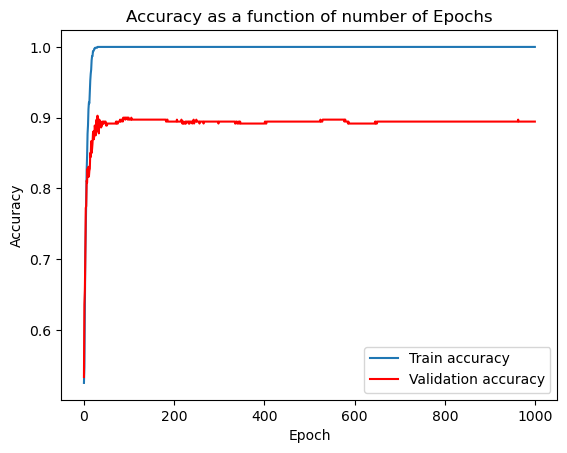

In [44]:
# your code here

epochs = [i for i in range(epochs)]
plt.plot(epochs,history.history['accuracy'],label="Train accuracy")
plt.plot(epochs,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

In [45]:
model_overfit.summary()

Model: "model_overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_228 (Dense)           (None, 100)               78500     
                                                                 
 dense_229 (Dense)           (None, 100)               10100     
                                                                 
 dense_230 (Dense)           (None, 100)               10100     
                                                                 
 dense_231 (Dense)           (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


<div class='exercise-r'>

**2.3.1**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.1"></a>
    
**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 
 - **YOU CAN** add flatten layers as you see fit.

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

## Data Augmentation

In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise

In [47]:
%%time
# your code here

X_train_aug = x_train.copy()
# Reshape the images to 3D tensors
X_train_aug = X_train_aug.values.reshape(-1, 28, 28, 1)

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,      # rotate the image up to 10 degrees
    width_shift_range=0.1,  # shift the image left or right by up to 10% of the width
    height_shift_range=0.1, # shift the image up or down by up to 10% of the height
    shear_range=0.1,        # apply shearing transformation with maximum of 10%
    zoom_range=0.1,         # zoom in or out by up to 10%
    fill_mode='nearest',    # fill the empty space with the nearest pixel value
    horizontal_flip=True,   # flip the image horizontally
    vertical_flip=True,    # do not flip the image vertically
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train_aug)

# Generate augmented images
augmented_images = np.empty((0, 28, 28, 1))
augmented_labels = np.empty((0,))

num_images = 1000

for X_batch, y_batch in datagen.flow(X_train_aug, y_train, batch_size=32):
    augmented_images = np.concatenate((augmented_images, X_batch))
    augmented_labels = np.concatenate((augmented_labels, y_batch))
    if len(augmented_images) >= num_images:
        break

# Convert the labels to integers
augmented_labels = augmented_labels.astype(int)

augmented_images = augmented_images.reshape((augmented_images.shape[0], -1))

X_train_augmented = np.concatenate((x_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

CPU times: user 340 ms, sys: 48.7 ms, total: 389 ms
Wall time: 391 ms


In [48]:
# your code here

std = 0.75

inputs = tf.keras.layers.Input(shape=(784,))
x = GaussianNoise(stddev=std, seed=109)(inputs)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

NN_model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
NN_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [49]:
%%time
epochs = 100
history=NN_model.fit(X_train_augmented,y_train_augmented,epochs=epochs,batch_size=128,validation_split=0.3)

Epoch 1/100
13/13 [==============================] - 1s 13ms/step - loss: 8.0666 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5120
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 1.5417 - accuracy: 0.5598 - val_loss: 0.6935 - val_accuracy: 0.4925
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.8082 - accuracy: 0.6401 - val_loss: 0.6930 - val_accuracy: 0.4955
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5733 - accuracy: 0.7057 - val_loss: 0.6922 - val_accuracy: 0.4970
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.5238 - accuracy: 0.7294 - val_loss: 0.6924 - val_accuracy: 0.4940
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.4563 - accuracy: 0.7654 - val_loss: 0.6917 - val_accuracy: 0.4955
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.7654 - val_loss: 0.6919 - val_accuracy: 0.4955
Epoch 8/100


Epoch 59/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1320 - accuracy: 0.9441 - val_loss: 0.6039 - val_accuracy: 0.7051
Epoch 60/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1317 - accuracy: 0.9479 - val_loss: 0.5990 - val_accuracy: 0.6976
Epoch 61/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1300 - accuracy: 0.9499 - val_loss: 0.5977 - val_accuracy: 0.7036
Epoch 62/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1276 - accuracy: 0.9479 - val_loss: 0.5897 - val_accuracy: 0.7126
Epoch 63/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1248 - accuracy: 0.9531 - val_loss: 0.5843 - val_accuracy: 0.7186
Epoch 64/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1230 - accuracy: 0.9505 - val_loss: 0.5793 - val_accuracy: 0.7141
Epoch 65/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1211 - accuracy: 0.9537 - val_loss: 0.5731 - val_accuracy: 0.7216
Epoch 

## Regularization

In [50]:
%%time 

# Define an early stopping callback that will stop training when the validation loss has not improved for 75 epochs and restore the weights from the best epoch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, restore_best_weights=True, verbose=1)

# Define a list of regularization strengths to test
Cs = [10**i for i in range(-4, 2)]

# Create an empty list to store the best validation accuracy achieved for each value of C
val_accs_l2 = []

# Loop through each value of C
for l in Cs:
    
    # Define an L2 regularization object with strength l
    l_reg = tf.keras.regularizers.L2(l)
    
    # Define the model architecture
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    
    # Train the model with early stopping callback
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    
    # Append the best validation accuracy achieved for this value of C to the list
    val_accs_l2.append(max(history.history['val_accuracy']))



Epoch 1/300
7/7 [==============================] - 1s 28ms/step - loss: 5.3115 - accuracy: 0.5393 - val_loss: 4.1811 - val_accuracy: 0.5194
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 2.1062 - accuracy: 0.6357 - val_loss: 1.7612 - val_accuracy: 0.6028
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 1.2009 - accuracy: 0.7369 - val_loss: 1.1197 - val_accuracy: 0.6778
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8126 - accuracy: 0.7500 - val_loss: 0.8706 - val_accuracy: 0.7028
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5108 - accuracy: 0.8083 - val_loss: 0.6538 - val_accuracy: 0.7639
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4057 - accuracy: 0.8440 - val_loss: 0.6214 - val_accuracy: 0.7833
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3606 - accuracy: 0.8667 - val_loss: 0.6127 - val_accuracy: 0.7778
Epoch 8/300
7/7 [=========

7/7 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.4432 - val_accuracy: 0.9028
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.4435 - val_accuracy: 0.9028
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.4431 - val_accuracy: 0.8972
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 1.0000 - val_loss: 0.4424 - val_accuracy: 0.9028
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.4404 - val_accuracy: 0.9000
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 1.0000 - val_loss: 0.4565 - val_accuracy: 0.8972
Epoch 65/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.4432 - val_accuracy: 0.9000
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.3828 - accuracy: 0.9881 - val_loss: 0.6290 - val_accuracy: 0.8750
Epoch 18/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3695 - accuracy: 0.9893 - val_loss: 0.6163 - val_accuracy: 0.8917
Epoch 19/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3617 - accuracy: 0.9940 - val_loss: 0.6066 - val_accuracy: 0.8944
Epoch 20/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3531 - accuracy: 0.9964 - val_loss: 0.6044 - val_accuracy: 0.8861
Epoch 21/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3465 - accuracy: 0.9976 - val_loss: 0.5977 - val_accuracy: 0.9000
Epoch 22/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3413 - accuracy: 0.9976 - val_loss: 0.5989 - val_accuracy: 0.8972
Epoch 23/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3367 - accuracy: 0.9976 - val_loss: 0.6110 - val_accuracy: 0.8750
Epoch 24/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.2616 - accuracy: 1.0000 - val_loss: 0.5882 - val_accuracy: 0.9139
Epoch 76/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2608 - accuracy: 1.0000 - val_loss: 0.5895 - val_accuracy: 0.9194
Epoch 77/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2601 - accuracy: 1.0000 - val_loss: 0.5920 - val_accuracy: 0.9111
Epoch 78/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2593 - accuracy: 1.0000 - val_loss: 0.5933 - val_accuracy: 0.9111
Epoch 79/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2585 - accuracy: 1.0000 - val_loss: 0.5958 - val_accuracy: 0.9083
Epoch 80/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2579 - accuracy: 1.0000 - val_loss: 0.5947 - val_accuracy: 0.9167
Epoch 81/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2572 - accuracy: 1.0000 - val_loss: 0.5929 - val_accuracy: 0.9139
Epoch 82/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 3.5552 - accuracy: 0.8631 - val_loss: 3.6646 - val_accuracy: 0.7889
Epoch 9/300
7/7 [==============================] - 0s 6ms/step - loss: 3.4598 - accuracy: 0.8798 - val_loss: 3.5806 - val_accuracy: 0.7889
Epoch 10/300
7/7 [==============================] - 0s 6ms/step - loss: 3.3625 - accuracy: 0.8964 - val_loss: 3.5129 - val_accuracy: 0.8111
Epoch 11/300
7/7 [==============================] - 0s 6ms/step - loss: 3.2762 - accuracy: 0.9143 - val_loss: 3.4525 - val_accuracy: 0.8167
Epoch 12/300
7/7 [==============================] - 0s 6ms/step - loss: 3.2075 - accuracy: 0.9214 - val_loss: 3.4074 - val_accuracy: 0.8306
Epoch 13/300
7/7 [==============================] - 0s 6ms/step - loss: 3.1404 - accuracy: 0.9298 - val_loss: 3.3537 - val_accuracy: 0.8278
Epoch 14/300
7/7 [==============================] - 0s 6ms/step - loss: 3.0760 - accuracy: 0.9476 - val_loss: 3.3150 - val_accuracy: 0.8278
Epoch 15/300
7/7 [================

7/7 [==============================] - 0s 6ms/step - loss: 1.8574 - accuracy: 1.0000 - val_loss: 2.2365 - val_accuracy: 0.8917
Epoch 67/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8432 - accuracy: 1.0000 - val_loss: 2.2212 - val_accuracy: 0.8944
Epoch 68/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8291 - accuracy: 1.0000 - val_loss: 2.2068 - val_accuracy: 0.8972
Epoch 69/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8151 - accuracy: 1.0000 - val_loss: 2.1923 - val_accuracy: 0.9000
Epoch 70/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8013 - accuracy: 1.0000 - val_loss: 2.1773 - val_accuracy: 0.8972
Epoch 71/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7877 - accuracy: 1.0000 - val_loss: 2.1632 - val_accuracy: 0.9083
Epoch 72/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7740 - accuracy: 1.0000 - val_loss: 2.1475 - val_accuracy: 0.8972
Epoch 73/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 1.2088 - accuracy: 1.0000 - val_loss: 1.5583 - val_accuracy: 0.9167
Epoch 125/300
7/7 [==============================] - 0s 6ms/step - loss: 1.2004 - accuracy: 1.0000 - val_loss: 1.5577 - val_accuracy: 0.9250
Epoch 126/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1918 - accuracy: 1.0000 - val_loss: 1.5371 - val_accuracy: 0.9139
Epoch 127/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1831 - accuracy: 1.0000 - val_loss: 1.5263 - val_accuracy: 0.9139
Epoch 128/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1748 - accuracy: 1.0000 - val_loss: 1.5185 - val_accuracy: 0.9139
Epoch 129/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1665 - accuracy: 1.0000 - val_loss: 1.5103 - val_accuracy: 0.9139
Epoch 130/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1579 - accuracy: 1.0000 - val_loss: 1.4985 - val_accuracy: 0.9139
Epoch 131/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8007 - accuracy: 1.0000 - val_loss: 1.1259 - val_accuracy: 0.9222
Epoch 183/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7951 - accuracy: 1.0000 - val_loss: 1.1226 - val_accuracy: 0.9222
Epoch 184/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7895 - accuracy: 1.0000 - val_loss: 1.1153 - val_accuracy: 0.9222
Epoch 185/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7840 - accuracy: 1.0000 - val_loss: 1.1133 - val_accuracy: 0.9222
Epoch 186/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7785 - accuracy: 1.0000 - val_loss: 1.1007 - val_accuracy: 0.9167
Epoch 187/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7730 - accuracy: 1.0000 - val_loss: 1.0958 - val_accuracy: 0.9222
Epoch 188/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7676 - accuracy: 1.0000 - val_loss: 1.0970 - val_accuracy: 0.9250
Epoch 189/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5977 - accuracy: 1.0000 - val_loss: 0.8040 - val_accuracy: 0.9444
Epoch 241/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5941 - accuracy: 1.0000 - val_loss: 0.8008 - val_accuracy: 0.9389
Epoch 242/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5903 - accuracy: 1.0000 - val_loss: 0.7998 - val_accuracy: 0.9417
Epoch 243/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5868 - accuracy: 1.0000 - val_loss: 0.7958 - val_accuracy: 0.9472
Epoch 244/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5830 - accuracy: 1.0000 - val_loss: 0.7939 - val_accuracy: 0.9444
Epoch 245/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5793 - accuracy: 1.0000 - val_loss: 0.7945 - val_accuracy: 0.9389
Epoch 246/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5758 - accuracy: 1.0000 - val_loss: 0.7909 - val_accuracy: 0.9417
Epoch 247/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4182 - accuracy: 1.0000 - val_loss: 0.6572 - val_accuracy: 0.9444
Epoch 299/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4157 - accuracy: 1.0000 - val_loss: 0.6531 - val_accuracy: 0.9444
Epoch 300/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4132 - accuracy: 1.0000 - val_loss: 0.6539 - val_accuracy: 0.9472
Epoch 1/300
7/7 [==============================] - 1s 27ms/step - loss: 51.3351 - accuracy: 0.4869 - val_loss: 42.3738 - val_accuracy: 0.5222
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 38.8188 - accuracy: 0.5714 - val_loss: 37.9247 - val_accuracy: 0.5667
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 36.5322 - accuracy: 0.6357 - val_loss: 35.4259 - val_accuracy: 0.6611
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 34.5644 - accuracy: 0.7226 - val_loss: 33.7129 - val_accuracy: 0.7000
Epoch 5/300
7/7 [=========

Epoch 56/300
7/7 [==============================] - 0s 6ms/step - loss: 7.8978 - accuracy: 1.0000 - val_loss: 7.9579 - val_accuracy: 0.9278
Epoch 57/300
7/7 [==============================] - 0s 6ms/step - loss: 7.7118 - accuracy: 1.0000 - val_loss: 7.7696 - val_accuracy: 0.9306
Epoch 58/300
7/7 [==============================] - 0s 6ms/step - loss: 7.5320 - accuracy: 1.0000 - val_loss: 7.5948 - val_accuracy: 0.9306
Epoch 59/300
7/7 [==============================] - 0s 6ms/step - loss: 7.3579 - accuracy: 1.0000 - val_loss: 7.4211 - val_accuracy: 0.9333
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 7.1870 - accuracy: 1.0000 - val_loss: 7.2501 - val_accuracy: 0.9389
Epoch 61/300
7/7 [==============================] - 0s 7ms/step - loss: 7.0218 - accuracy: 1.0000 - val_loss: 7.1049 - val_accuracy: 0.9167
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 6.8623 - accuracy: 1.0000 - val_loss: 6.9289 - val_accuracy: 0.9333
Epoch 63/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 2.5218 - accuracy: 0.9833 - val_loss: 2.5950 - val_accuracy: 0.9389
Epoch 115/300
7/7 [==============================] - 0s 6ms/step - loss: 2.4627 - accuracy: 0.9905 - val_loss: 2.5503 - val_accuracy: 0.9278
Epoch 116/300
7/7 [==============================] - 0s 6ms/step - loss: 2.4101 - accuracy: 0.9964 - val_loss: 2.5084 - val_accuracy: 0.9333
Epoch 117/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3621 - accuracy: 0.9964 - val_loss: 2.4719 - val_accuracy: 0.9361
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 2.3195 - accuracy: 0.9964 - val_loss: 2.4379 - val_accuracy: 0.9417
Epoch 119/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2790 - accuracy: 0.9988 - val_loss: 2.3918 - val_accuracy: 0.9306
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 2.2327 - accuracy: 0.9988 - val_loss: 2.3597 - val_accuracy: 0.9361
Epoch 121/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.0364 - accuracy: 1.0000 - val_loss: 1.1833 - val_accuracy: 0.9417
Epoch 173/300
7/7 [==============================] - 0s 7ms/step - loss: 1.0203 - accuracy: 1.0000 - val_loss: 1.1718 - val_accuracy: 0.9417
Epoch 174/300
7/7 [==============================] - 0s 8ms/step - loss: 1.0061 - accuracy: 1.0000 - val_loss: 1.1569 - val_accuracy: 0.9361
Epoch 175/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9915 - accuracy: 1.0000 - val_loss: 1.1374 - val_accuracy: 0.9389
Epoch 176/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9773 - accuracy: 1.0000 - val_loss: 1.1228 - val_accuracy: 0.9389
Epoch 177/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9636 - accuracy: 1.0000 - val_loss: 1.1093 - val_accuracy: 0.9417
Epoch 178/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9504 - accuracy: 1.0000 - val_loss: 1.0946 - val_accuracy: 0.9417
Epoch 179/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5025 - accuracy: 1.0000 - val_loss: 0.6448 - val_accuracy: 0.9444
Epoch 231/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4966 - accuracy: 1.0000 - val_loss: 0.6394 - val_accuracy: 0.9417
Epoch 232/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4909 - accuracy: 1.0000 - val_loss: 0.6385 - val_accuracy: 0.9472
Epoch 233/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4874 - accuracy: 1.0000 - val_loss: 0.6410 - val_accuracy: 0.9361
Epoch 234/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4843 - accuracy: 1.0000 - val_loss: 0.6229 - val_accuracy: 0.9417
Epoch 235/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4773 - accuracy: 1.0000 - val_loss: 0.6191 - val_accuracy: 0.9389
Epoch 236/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4711 - accuracy: 1.0000 - val_loss: 0.6296 - val_accuracy: 0.9389
Epoch 237/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.2726 - accuracy: 1.0000 - val_loss: 0.4227 - val_accuracy: 0.9389
Epoch 289/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2687 - accuracy: 1.0000 - val_loss: 0.4205 - val_accuracy: 0.9444
Epoch 290/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2665 - accuracy: 1.0000 - val_loss: 0.4162 - val_accuracy: 0.9417
Epoch 291/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2637 - accuracy: 1.0000 - val_loss: 0.4224 - val_accuracy: 0.9389
Epoch 292/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2618 - accuracy: 1.0000 - val_loss: 0.4126 - val_accuracy: 0.9389
Epoch 293/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2588 - accuracy: 1.0000 - val_loss: 0.4091 - val_accuracy: 0.9444
Epoch 294/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2556 - accuracy: 1.0000 - val_loss: 0.4058 - val_accuracy: 0.9389
Epoch 295/300
7/7 [========

Epoch 46/300
7/7 [==============================] - 0s 6ms/step - loss: 7.5279 - accuracy: 0.9857 - val_loss: 7.3695 - val_accuracy: 0.9444
Epoch 47/300
7/7 [==============================] - 0s 6ms/step - loss: 7.1530 - accuracy: 0.9762 - val_loss: 7.0527 - val_accuracy: 0.8861
Epoch 48/300
7/7 [==============================] - 0s 6ms/step - loss: 6.8153 - accuracy: 0.9643 - val_loss: 6.6752 - val_accuracy: 0.9278
Epoch 49/300
7/7 [==============================] - 0s 6ms/step - loss: 6.4586 - accuracy: 0.9750 - val_loss: 6.3015 - val_accuracy: 0.9500
Epoch 50/300
7/7 [==============================] - 0s 6ms/step - loss: 6.1265 - accuracy: 0.9786 - val_loss: 5.9954 - val_accuracy: 0.9500
Epoch 51/300
7/7 [==============================] - 0s 6ms/step - loss: 5.8247 - accuracy: 0.9810 - val_loss: 5.7250 - val_accuracy: 0.9583
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 5.5502 - accuracy: 0.9798 - val_loss: 5.4389 - val_accuracy: 0.9556
Epoch 53/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 0.8695 - accuracy: 0.9833 - val_loss: 0.9050 - val_accuracy: 0.9556
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8484 - accuracy: 0.9833 - val_loss: 0.8994 - val_accuracy: 0.9333
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8341 - accuracy: 0.9869 - val_loss: 0.8667 - val_accuracy: 0.9556
Epoch 107/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8063 - accuracy: 0.9845 - val_loss: 0.8465 - val_accuracy: 0.9583
Epoch 108/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7904 - accuracy: 0.9845 - val_loss: 0.8358 - val_accuracy: 0.9472
Epoch 109/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7746 - accuracy: 0.9845 - val_loss: 0.8113 - val_accuracy: 0.9556
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 0.7608 - accuracy: 0.9821 - val_loss: 0.7976 - val_accuracy: 0.9528
Epoch 111/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3767 - accuracy: 0.9881 - val_loss: 0.4340 - val_accuracy: 0.9500
Epoch 163/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3747 - accuracy: 0.9929 - val_loss: 0.4880 - val_accuracy: 0.9250
Epoch 164/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4089 - accuracy: 0.9702 - val_loss: 0.4267 - val_accuracy: 0.9500
Epoch 165/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3866 - accuracy: 0.9738 - val_loss: 0.4464 - val_accuracy: 0.9361
Epoch 166/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3936 - accuracy: 0.9798 - val_loss: 0.4369 - val_accuracy: 0.9500
Epoch 167/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3787 - accuracy: 0.9833 - val_loss: 0.4217 - val_accuracy: 0.9528
Epoch 168/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3628 - accuracy: 0.9893 - val_loss: 0.4205 - val_accuracy: 0.9556
Epoch 169/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.3103 - accuracy: 0.9869 - val_loss: 0.3649 - val_accuracy: 0.9528
Epoch 221/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3214 - accuracy: 0.9810 - val_loss: 0.3839 - val_accuracy: 0.9417
Epoch 222/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3391 - accuracy: 0.9702 - val_loss: 0.4106 - val_accuracy: 0.9333
Epoch 223/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3255 - accuracy: 0.9750 - val_loss: 0.4134 - val_accuracy: 0.9194
Epoch 224/300
7/7 [==============================] - 0s 6ms/step - loss: 0.3006 - accuracy: 0.9881 - val_loss: 0.3673 - val_accuracy: 0.9472
Epoch 225/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2932 - accuracy: 0.9929 - val_loss: 0.3898 - val_accuracy: 0.9417
Epoch 226/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2984 - accuracy: 0.9893 - val_loss: 0.3759 - val_accuracy: 0.9417
Epoch 227/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.2655 - accuracy: 0.9976 - val_loss: 0.3424 - val_accuracy: 0.9472
Epoch 279/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2614 - accuracy: 0.9952 - val_loss: 0.3458 - val_accuracy: 0.9444
Epoch 280/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2636 - accuracy: 0.9988 - val_loss: 0.3426 - val_accuracy: 0.9528
Epoch 281/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2830 - accuracy: 0.9821 - val_loss: 0.3525 - val_accuracy: 0.9417
Epoch 282/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2619 - accuracy: 0.9976 - val_loss: 0.3776 - val_accuracy: 0.9389
Epoch 283/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2823 - accuracy: 0.9869 - val_loss: 0.3495 - val_accuracy: 0.9444
Epoch 284/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2636 - accuracy: 0.9952 - val_loss: 0.3508 - val_accuracy: 0.9500
Epoch 285/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 8.0857 - accuracy: 0.7190 - val_loss: 7.2092 - val_accuracy: 0.6639
Epoch 36/300
7/7 [==============================] - 0s 6ms/step - loss: 6.6961 - accuracy: 0.5774 - val_loss: 5.9750 - val_accuracy: 0.5167
Epoch 37/300
7/7 [==============================] - 0s 6ms/step - loss: 5.5540 - accuracy: 0.4750 - val_loss: 4.9623 - val_accuracy: 0.5056
Epoch 38/300
7/7 [==============================] - 0s 6ms/step - loss: 4.6180 - accuracy: 0.4750 - val_loss: 4.1342 - val_accuracy: 0.5056
Epoch 39/300
7/7 [==============================] - 0s 6ms/step - loss: 3.8534 - accuracy: 0.4750 - val_loss: 3.4588 - val_accuracy: 0.5056
Epoch 40/300
7/7 [==============================] - 0s 6ms/step - loss: 3.2306 - accuracy: 0.4750 - val_loss: 2.9096 - val_accuracy: 0.5056
Epoch 41/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7247 - accuracy: 0.4750 - val_loss: 2.4645 - val_accuracy: 0.5056
Epoch 42/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5250 - val_loss: 0.6940 - val_accuracy: 0.4944
Epoch 94/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6940 - val_accuracy: 0.4944
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6940 - val_accuracy: 0.4944
Epoch 96/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.4944
Epoch 97/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.4944
Epoch 98/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.4944
Epoch 99/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6941 - val_accuracy: 0.4944
Epoch 100/300
7/7 [==============

7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 152/300
7/7 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6951 - val_accuracy: 0.4944
Epoch 153/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5250 - val_loss: 0.6949 - val_accuracy: 0.4944
Epoch 153: early stopping
CPU times: user 1min 23s, sys: 13.7 s, total: 1min 37s
Wall time: 58.4 s


In [51]:
val_accs_l1 = []
for l in Cs:
    l_reg = tf.keras.regularizers.L1(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_l1.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 29ms/step - loss: 12.7105 - accuracy: 0.5298 - val_loss: 6.0660 - val_accuracy: 0.5278
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4.0287 - accuracy: 0.5179 - val_loss: 2.7007 - val_accuracy: 0.5389
Epoch 3/300
7/7 [==============================] - 0s 6ms/step - loss: 1.9644 - accuracy: 0.6345 - val_loss: 1.8530 - val_accuracy: 0.6111
Epoch 4/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6018 - accuracy: 0.6881 - val_loss: 2.0756 - val_accuracy: 0.6361
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4003 - accuracy: 0.7000 - val_loss: 1.4615 - val_accuracy: 0.6972
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1936 - accuracy: 0.7429 - val_loss: 1.1792 - val_accuracy: 0.7389
Epoch 7/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9630 - accuracy: 0.8036 - val_loss: 1.0733 - val_accuracy: 0.7806
Epoch 8/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.4256 - accuracy: 1.0000 - val_loss: 0.9463 - val_accuracy: 0.8750
Epoch 60/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4248 - accuracy: 1.0000 - val_loss: 0.9487 - val_accuracy: 0.8778
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4239 - accuracy: 1.0000 - val_loss: 0.9527 - val_accuracy: 0.8778
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4232 - accuracy: 1.0000 - val_loss: 0.9552 - val_accuracy: 0.8750
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4226 - accuracy: 1.0000 - val_loss: 0.9604 - val_accuracy: 0.8750
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4217 - accuracy: 1.0000 - val_loss: 0.9594 - val_accuracy: 0.8750
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4209 - accuracy: 1.0000 - val_loss: 0.9607 - val_accuracy: 0.8750
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 4.2258 - accuracy: 0.9619 - val_loss: 4.5393 - val_accuracy: 0.8278
Epoch 20/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1803 - accuracy: 0.9690 - val_loss: 4.3517 - val_accuracy: 0.8833
Epoch 21/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1310 - accuracy: 0.9750 - val_loss: 4.3636 - val_accuracy: 0.8667
Epoch 22/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1123 - accuracy: 0.9631 - val_loss: 4.4181 - val_accuracy: 0.8333
Epoch 23/300
7/7 [==============================] - 0s 6ms/step - loss: 4.0424 - accuracy: 0.9857 - val_loss: 4.2427 - val_accuracy: 0.9083
Epoch 24/300
7/7 [==============================] - 0s 6ms/step - loss: 3.9965 - accuracy: 0.9940 - val_loss: 4.2107 - val_accuracy: 0.9111
Epoch 25/300
7/7 [==============================] - 0s 6ms/step - loss: 3.9572 - accuracy: 0.9964 - val_loss: 4.1870 - val_accuracy: 0.9083
Epoch 26/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 2.7492 - accuracy: 1.0000 - val_loss: 3.0425 - val_accuracy: 0.9194
Epoch 78/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7310 - accuracy: 1.0000 - val_loss: 3.0232 - val_accuracy: 0.9194
Epoch 79/300
7/7 [==============================] - 0s 6ms/step - loss: 2.7126 - accuracy: 1.0000 - val_loss: 3.0044 - val_accuracy: 0.9083
Epoch 80/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6945 - accuracy: 1.0000 - val_loss: 2.9938 - val_accuracy: 0.9139
Epoch 81/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6769 - accuracy: 1.0000 - val_loss: 2.9761 - val_accuracy: 0.9167
Epoch 82/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6590 - accuracy: 1.0000 - val_loss: 2.9540 - val_accuracy: 0.9167
Epoch 83/300
7/7 [==============================] - 0s 6ms/step - loss: 2.6411 - accuracy: 1.0000 - val_loss: 2.9357 - val_accuracy: 0.9083
Epoch 84/300
7/7 [===============

7/7 [==============================] - 0s 6ms/step - loss: 1.8751 - accuracy: 1.0000 - val_loss: 2.1798 - val_accuracy: 0.9333
Epoch 136/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8629 - accuracy: 1.0000 - val_loss: 2.1643 - val_accuracy: 0.9250
Epoch 137/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8507 - accuracy: 1.0000 - val_loss: 2.1505 - val_accuracy: 0.9194
Epoch 138/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8391 - accuracy: 1.0000 - val_loss: 2.1465 - val_accuracy: 0.9250
Epoch 139/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8269 - accuracy: 1.0000 - val_loss: 2.1364 - val_accuracy: 0.9167
Epoch 140/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8154 - accuracy: 1.0000 - val_loss: 2.1206 - val_accuracy: 0.9222
Epoch 141/300
7/7 [==============================] - 0s 6ms/step - loss: 1.8027 - accuracy: 1.0000 - val_loss: 2.1040 - val_accuracy: 0.9194
Epoch 142/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.3619 - accuracy: 1.0000 - val_loss: 1.7121 - val_accuracy: 0.9250
Epoch 194/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3525 - accuracy: 1.0000 - val_loss: 1.6999 - val_accuracy: 0.9222
Epoch 195/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3429 - accuracy: 1.0000 - val_loss: 1.6913 - val_accuracy: 0.9194
Epoch 196/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3335 - accuracy: 1.0000 - val_loss: 1.6834 - val_accuracy: 0.9250
Epoch 197/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3242 - accuracy: 1.0000 - val_loss: 1.6762 - val_accuracy: 0.9250
Epoch 198/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3150 - accuracy: 1.0000 - val_loss: 1.6661 - val_accuracy: 0.9194
Epoch 199/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3060 - accuracy: 1.0000 - val_loss: 1.6577 - val_accuracy: 0.9194
Epoch 200/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.9083 - accuracy: 1.0000 - val_loss: 1.2637 - val_accuracy: 0.9361
Epoch 252/300
7/7 [==============================] - 0s 6ms/step - loss: 0.9019 - accuracy: 1.0000 - val_loss: 1.2565 - val_accuracy: 0.9361
Epoch 253/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8956 - accuracy: 1.0000 - val_loss: 1.2497 - val_accuracy: 0.9361
Epoch 254/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8893 - accuracy: 1.0000 - val_loss: 1.2432 - val_accuracy: 0.9361
Epoch 255/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8830 - accuracy: 1.0000 - val_loss: 1.2366 - val_accuracy: 0.9361
Epoch 256/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8769 - accuracy: 1.0000 - val_loss: 1.2300 - val_accuracy: 0.9306
Epoch 257/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8707 - accuracy: 1.0000 - val_loss: 1.2232 - val_accuracy: 0.9361
Epoch 258/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 36.4825 - accuracy: 0.8976 - val_loss: 35.9050 - val_accuracy: 0.8167
Epoch 10/300
7/7 [==============================] - 0s 6ms/step - loss: 35.0498 - accuracy: 0.9143 - val_loss: 34.4212 - val_accuracy: 0.8444
Epoch 11/300
7/7 [==============================] - 0s 7ms/step - loss: 33.6730 - accuracy: 0.9417 - val_loss: 33.1427 - val_accuracy: 0.8472
Epoch 12/300
7/7 [==============================] - 0s 6ms/step - loss: 32.4159 - accuracy: 0.9548 - val_loss: 31.9609 - val_accuracy: 0.8278
Epoch 13/300
7/7 [==============================] - 0s 6ms/step - loss: 31.2416 - accuracy: 0.9488 - val_loss: 30.7705 - val_accuracy: 0.8694
Epoch 14/300
7/7 [==============================] - 0s 6ms/step - loss: 30.1165 - accuracy: 0.9762 - val_loss: 29.7106 - val_accuracy: 0.8583
Epoch 15/300
7/7 [==============================] - 0s 6ms/step - loss: 29.0641 - accuracy: 0.9786 - val_loss: 28.6700 - val_accuracy: 0.8806
Epoch 16/300
7/7 [=

Epoch 67/300
7/7 [==============================] - 0s 6ms/step - loss: 7.3477 - accuracy: 0.9976 - val_loss: 7.4454 - val_accuracy: 0.9139
Epoch 68/300
7/7 [==============================] - 0s 6ms/step - loss: 7.1888 - accuracy: 0.9940 - val_loss: 7.2801 - val_accuracy: 0.9083
Epoch 69/300
7/7 [==============================] - 0s 6ms/step - loss: 7.0247 - accuracy: 0.9940 - val_loss: 7.1129 - val_accuracy: 0.9167
Epoch 70/300
7/7 [==============================] - 0s 6ms/step - loss: 6.8509 - accuracy: 1.0000 - val_loss: 6.9275 - val_accuracy: 0.9278
Epoch 71/300
7/7 [==============================] - 0s 6ms/step - loss: 6.6926 - accuracy: 1.0000 - val_loss: 6.7686 - val_accuracy: 0.9306
Epoch 72/300
7/7 [==============================] - 0s 6ms/step - loss: 6.5399 - accuracy: 1.0000 - val_loss: 6.6159 - val_accuracy: 0.9361
Epoch 73/300
7/7 [==============================] - 0s 6ms/step - loss: 6.3925 - accuracy: 1.0000 - val_loss: 6.4725 - val_accuracy: 0.9361
Epoch 74/300
7/7 [==

7/7 [==============================] - 0s 7ms/step - loss: 2.6570 - accuracy: 0.9988 - val_loss: 2.7703 - val_accuracy: 0.9472
Epoch 126/300
7/7 [==============================] - 0s 8ms/step - loss: 2.6187 - accuracy: 1.0000 - val_loss: 2.7491 - val_accuracy: 0.9528
Epoch 127/300
7/7 [==============================] - 0s 7ms/step - loss: 2.5858 - accuracy: 0.9988 - val_loss: 2.7126 - val_accuracy: 0.9500
Epoch 128/300
7/7 [==============================] - 0s 6ms/step - loss: 2.5557 - accuracy: 0.9940 - val_loss: 2.6843 - val_accuracy: 0.9361
Epoch 129/300
7/7 [==============================] - 0s 6ms/step - loss: 2.5213 - accuracy: 0.9964 - val_loss: 2.6622 - val_accuracy: 0.9306
Epoch 130/300
7/7 [==============================] - 0s 6ms/step - loss: 2.5477 - accuracy: 0.9655 - val_loss: 3.4721 - val_accuracy: 0.6250
Epoch 131/300
7/7 [==============================] - 0s 6ms/step - loss: 2.9152 - accuracy: 0.8833 - val_loss: 2.9064 - val_accuracy: 0.9472
Epoch 132/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4555 - accuracy: 1.0000 - val_loss: 1.6002 - val_accuracy: 0.9556
Epoch 184/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4421 - accuracy: 1.0000 - val_loss: 1.5908 - val_accuracy: 0.9528
Epoch 185/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4281 - accuracy: 1.0000 - val_loss: 1.5726 - val_accuracy: 0.9556
Epoch 186/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4142 - accuracy: 1.0000 - val_loss: 1.5591 - val_accuracy: 0.9528
Epoch 187/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4029 - accuracy: 1.0000 - val_loss: 1.5562 - val_accuracy: 0.9500
Epoch 188/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3903 - accuracy: 1.0000 - val_loss: 1.5372 - val_accuracy: 0.9528
Epoch 189/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3785 - accuracy: 1.0000 - val_loss: 1.5235 - val_accuracy: 0.9500
Epoch 190/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.8942 - accuracy: 1.0000 - val_loss: 1.0629 - val_accuracy: 0.9417
Epoch 242/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8867 - accuracy: 1.0000 - val_loss: 1.0737 - val_accuracy: 0.9444
Epoch 243/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8807 - accuracy: 1.0000 - val_loss: 1.0565 - val_accuracy: 0.9389
Epoch 244/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8738 - accuracy: 1.0000 - val_loss: 1.0438 - val_accuracy: 0.9444
Epoch 245/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8646 - accuracy: 1.0000 - val_loss: 1.0353 - val_accuracy: 0.9472
Epoch 246/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8584 - accuracy: 1.0000 - val_loss: 1.0675 - val_accuracy: 0.9250
Epoch 247/300
7/7 [==============================] - 0s 6ms/step - loss: 0.8594 - accuracy: 1.0000 - val_loss: 1.0341 - val_accuracy: 0.9417
Epoch 248/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 0.5799 - accuracy: 1.0000 - val_loss: 0.7613 - val_accuracy: 0.9444
Epoch 300/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5759 - accuracy: 1.0000 - val_loss: 0.7565 - val_accuracy: 0.9444
Epoch 1/300
7/7 [==============================] - 1s 30ms/step - loss: 491.5885 - accuracy: 0.5155 - val_loss: 464.8889 - val_accuracy: 0.5583
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 449.5654 - accuracy: 0.6202 - val_loss: 426.8801 - val_accuracy: 0.6333
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 411.2611 - accuracy: 0.7107 - val_loss: 388.5988 - val_accuracy: 0.7111
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 373.2923 - accuracy: 0.7548 - val_loss: 351.0626 - val_accuracy: 0.7444
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 336.2773 - accuracy: 0.8095 - val_loss: 314.8818 - val_accuracy: 0.7583
Epoch 6/300
7/7 

Epoch 57/300
7/7 [==============================] - 0s 6ms/step - loss: 5.0505 - accuracy: 0.9167 - val_loss: 4.9471 - val_accuracy: 0.8944
Epoch 58/300
7/7 [==============================] - 0s 6ms/step - loss: 4.8754 - accuracy: 0.9226 - val_loss: 4.7766 - val_accuracy: 0.9000
Epoch 59/300
7/7 [==============================] - 0s 6ms/step - loss: 4.7166 - accuracy: 0.9131 - val_loss: 4.6184 - val_accuracy: 0.9528
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 4.5796 - accuracy: 0.9048 - val_loss: 4.5119 - val_accuracy: 0.9417
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 4.4409 - accuracy: 0.9119 - val_loss: 4.3405 - val_accuracy: 0.9139
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 4.2937 - accuracy: 0.9036 - val_loss: 4.2200 - val_accuracy: 0.8944
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 4.1821 - accuracy: 0.9024 - val_loss: 4.1092 - val_accuracy: 0.9028
Epoch 64/300
7/7 [==

7/7 [==============================] - 0s 6ms/step - loss: 1.8025 - accuracy: 0.9321 - val_loss: 1.7910 - val_accuracy: 0.9417
Epoch 116/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7797 - accuracy: 0.9357 - val_loss: 1.7749 - val_accuracy: 0.9500
Epoch 117/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7671 - accuracy: 0.9405 - val_loss: 1.7716 - val_accuracy: 0.9083
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7511 - accuracy: 0.9321 - val_loss: 1.7636 - val_accuracy: 0.9556
Epoch 119/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7515 - accuracy: 0.9321 - val_loss: 1.7429 - val_accuracy: 0.9528
Epoch 120/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7370 - accuracy: 0.9262 - val_loss: 1.7315 - val_accuracy: 0.9083
Epoch 121/300
7/7 [==============================] - 0s 6ms/step - loss: 1.7260 - accuracy: 0.9333 - val_loss: 1.7279 - val_accuracy: 0.9111
Epoch 122/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4814 - accuracy: 0.9405 - val_loss: 1.5277 - val_accuracy: 0.8722
Epoch 174/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4702 - accuracy: 0.9345 - val_loss: 1.4711 - val_accuracy: 0.9444
Epoch 175/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4618 - accuracy: 0.9500 - val_loss: 1.4824 - val_accuracy: 0.9500
Epoch 176/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4675 - accuracy: 0.9417 - val_loss: 1.4789 - val_accuracy: 0.9417
Epoch 177/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4814 - accuracy: 0.9345 - val_loss: 1.4828 - val_accuracy: 0.9528
Epoch 178/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4624 - accuracy: 0.9476 - val_loss: 1.4813 - val_accuracy: 0.9083
Epoch 179/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4601 - accuracy: 0.9512 - val_loss: 1.4638 - val_accuracy: 0.9444
Epoch 180/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4565 - accuracy: 0.9333 - val_loss: 1.4536 - val_accuracy: 0.9583
Epoch 232/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4377 - accuracy: 0.9476 - val_loss: 1.4424 - val_accuracy: 0.9583
Epoch 233/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4527 - accuracy: 0.9405 - val_loss: 1.5055 - val_accuracy: 0.8944
Epoch 234/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4374 - accuracy: 0.9429 - val_loss: 1.4290 - val_accuracy: 0.9556
Epoch 235/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4348 - accuracy: 0.9524 - val_loss: 1.4350 - val_accuracy: 0.9583
Epoch 236/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4193 - accuracy: 0.9595 - val_loss: 1.4280 - val_accuracy: 0.9444
Epoch 237/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4151 - accuracy: 0.9583 - val_loss: 1.4292 - val_accuracy: 0.9444
Epoch 238/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 1.4073 - accuracy: 0.9488 - val_loss: 1.4283 - val_accuracy: 0.9528
Epoch 290/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4118 - accuracy: 0.9536 - val_loss: 1.4371 - val_accuracy: 0.9167
Epoch 291/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3958 - accuracy: 0.9595 - val_loss: 1.4153 - val_accuracy: 0.9556
Epoch 292/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3896 - accuracy: 0.9679 - val_loss: 1.4087 - val_accuracy: 0.9583
Epoch 293/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3884 - accuracy: 0.9631 - val_loss: 1.4161 - val_accuracy: 0.9417
Epoch 294/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3906 - accuracy: 0.9631 - val_loss: 1.4133 - val_accuracy: 0.9611
Epoch 295/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3847 - accuracy: 0.9667 - val_loss: 1.4099 - val_accuracy: 0.9444
Epoch 296/300
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 12.1893 - accuracy: 0.5250 - val_loss: 12.2210 - val_accuracy: 0.4944
Epoch 47/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1988 - accuracy: 0.5250 - val_loss: 12.1756 - val_accuracy: 0.4944
Epoch 48/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1878 - accuracy: 0.5250 - val_loss: 12.1918 - val_accuracy: 0.4944
Epoch 49/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1892 - accuracy: 0.5250 - val_loss: 12.1972 - val_accuracy: 0.4944
Epoch 50/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2097 - accuracy: 0.5250 - val_loss: 12.2344 - val_accuracy: 0.4944
Epoch 51/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2221 - accuracy: 0.5250 - val_loss: 12.1945 - val_accuracy: 0.4944
Epoch 52/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1809 - accuracy: 0.5250 - val_loss: 12.1772 - val_accuracy: 0.4944
Epoch 53/300
7/7 [=

Epoch 104/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1807 - accuracy: 0.5250 - val_loss: 12.1673 - val_accuracy: 0.4944
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1715 - accuracy: 0.5250 - val_loss: 12.2087 - val_accuracy: 0.4944
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1990 - accuracy: 0.5250 - val_loss: 12.2575 - val_accuracy: 0.4944
Epoch 107/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2294 - accuracy: 0.5250 - val_loss: 12.1799 - val_accuracy: 0.4944
Epoch 108/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2180 - accuracy: 0.5250 - val_loss: 12.1664 - val_accuracy: 0.4944
Epoch 109/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1939 - accuracy: 0.5250 - val_loss: 12.2144 - val_accuracy: 0.4944
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 12.2196 - accuracy: 0.5250 - val_loss: 12.2123 - val_accuracy: 0.4944

7/7 [==============================] - 0s 6ms/step - loss: 121.7783 - accuracy: 0.5250 - val_loss: 121.6305 - val_accuracy: 0.4944
Epoch 45/300
7/7 [==============================] - 0s 6ms/step - loss: 121.5086 - accuracy: 0.5250 - val_loss: 121.5334 - val_accuracy: 0.4944
Epoch 46/300
7/7 [==============================] - 0s 6ms/step - loss: 121.8033 - accuracy: 0.5250 - val_loss: 121.6911 - val_accuracy: 0.4944
Epoch 47/300
7/7 [==============================] - 0s 6ms/step - loss: 121.6480 - accuracy: 0.5250 - val_loss: 121.5793 - val_accuracy: 0.4944
Epoch 48/300
7/7 [==============================] - 0s 6ms/step - loss: 121.7224 - accuracy: 0.5250 - val_loss: 121.6025 - val_accuracy: 0.4944
Epoch 49/300
7/7 [==============================] - 0s 6ms/step - loss: 121.6856 - accuracy: 0.5250 - val_loss: 121.7231 - val_accuracy: 0.4944
Epoch 50/300
7/7 [==============================] - 0s 6ms/step - loss: 121.8517 - accuracy: 0.5250 - val_loss: 121.6018 - val_accuracy: 0.4944
Epoch

Epoch 101/300
7/7 [==============================] - 0s 6ms/step - loss: 121.7300 - accuracy: 0.5250 - val_loss: 121.6310 - val_accuracy: 0.4944
Epoch 102/300
7/7 [==============================] - 0s 6ms/step - loss: 121.9355 - accuracy: 0.5250 - val_loss: 121.8818 - val_accuracy: 0.4944
Epoch 103/300
7/7 [==============================] - 0s 6ms/step - loss: 121.7753 - accuracy: 0.5250 - val_loss: 121.4830 - val_accuracy: 0.4944
Epoch 104/300
7/7 [==============================] - 0s 6ms/step - loss: 121.5469 - accuracy: 0.5250 - val_loss: 121.9869 - val_accuracy: 0.4944
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 121.5268 - accuracy: 0.5250 - val_loss: 121.5898 - val_accuracy: 0.4944
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 121.7921 - accuracy: 0.5250 - val_loss: 121.6648 - val_accuracy: 0.4944
Epoch 107/300
7/7 [==============================] - 0s 6ms/step - loss: 121.8083 - accuracy: 0.5250 - val_loss: 121.4176 - val_ac

7/7 [==============================] - 0s 6ms/step - loss: 121.7417 - accuracy: 0.5250 - val_loss: 122.0316 - val_accuracy: 0.4944
Epoch 158/300
7/7 [==============================] - 0s 7ms/step - loss: 121.9538 - accuracy: 0.5250 - val_loss: 121.7884 - val_accuracy: 0.4944
Epoch 158: early stopping


In [52]:
regularization_dic = {'Regularization Method':['L1', 'L2'], 
                     'Max Validation Accuracy':[max(val_accs_l1), max(val_accs_l2)],
                     'Value of C':[Cs[val_accs_l1.index(max(val_accs_l1))], 
                                   Cs[val_accs_l2.index(max(val_accs_l2))]]}

reg_df  = pd.DataFrame.from_dict(regularization_dic).set_index('Regularization Method')
reg_df

,Max Validation Accuracy,Value of C
Regularization Method,,
L1,0.963889,0.1
L2,0.963889,1.0


## Dropout

In [53]:
C = reg_df['Value of C'].max()
l_reg = tf.keras.regularizers.L1(C) if reg_df.idxmax()[0] == 'L1' else tf.keras.regularizers.L2(C)

In [54]:
# Define a list of dropout rates to test
Ds = [0.05,0.1,0.2,0.3,0.4]

# Create an empty list to store validation accuracies for each dropout rate
dropout_validation_accuracies = []

# Loop through each dropout rate in the list
for d in Ds:
    
    # Define the input layer of the model
    inputs = tf.keras.layers.Input(shape=(784,))
    
    # Define the first hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dropout(d)(x)
    
    # Define the second hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)
    
    # Define the third hidden layer with ReLU activation and L2 regularization, and apply dropout
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)

    # Define the output layer with sigmoid activation
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    
    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    
    # Fit the model to the training data with early stopping
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    
    # Append the maximum validation accuracy achieved during training to the list of validation accuracies
    dropout_validation_accuracies.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 32ms/step - loss: 4705.7715 - accuracy: 0.5024 - val_loss: 4323.1494 - val_accuracy: 0.4917
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4083.5662 - accuracy: 0.5107 - val_loss: 3730.9517 - val_accuracy: 0.5111
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 3510.4719 - accuracy: 0.4940 - val_loss: 3187.2239 - val_accuracy: 0.5556
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 2985.6741 - accuracy: 0.5357 - val_loss: 2691.8525 - val_accuracy: 0.5694
Epoch 5/300
7/7 [==============================] - 0s 7ms/step - loss: 2510.3374 - accuracy: 0.5452 - val_loss: 2246.7341 - val_accuracy: 0.5722
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 2084.1257 - accuracy: 0.5464 - val_loss: 1849.2714 - val_accuracy: 0.5917
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 1706.2722 - accuracy: 0.5655 - val_loss: 1501.5750 - val_a

7/7 [==============================] - 0s 6ms/step - loss: 12.0582 - accuracy: 0.5250 - val_loss: 12.0782 - val_accuracy: 0.4944
Epoch 59/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0831 - accuracy: 0.5250 - val_loss: 12.0748 - val_accuracy: 0.4944
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0692 - accuracy: 0.5250 - val_loss: 12.0925 - val_accuracy: 0.4944
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0817 - accuracy: 0.5250 - val_loss: 12.0627 - val_accuracy: 0.4944
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0652 - accuracy: 0.5250 - val_loss: 12.0493 - val_accuracy: 0.4944
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0482 - accuracy: 0.5250 - val_loss: 12.1018 - val_accuracy: 0.4944
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0937 - accuracy: 0.5250 - val_loss: 12.0929 - val_accuracy: 0.4944
Epoch 65/300
7/7 [=

Epoch 116/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0908 - accuracy: 0.5250 - val_loss: 12.0902 - val_accuracy: 0.4944
Epoch 117/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0707 - accuracy: 0.5250 - val_loss: 12.0614 - val_accuracy: 0.4944
Epoch 118/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0611 - accuracy: 0.5250 - val_loss: 12.0560 - val_accuracy: 0.4944
Epoch 119/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0747 - accuracy: 0.5250 - val_loss: 12.0875 - val_accuracy: 0.4944
Epoch 120/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0822 - accuracy: 0.5250 - val_loss: 12.1207 - val_accuracy: 0.4944
Epoch 120: early stopping
Epoch 1/300
7/7 [==============================] - 1s 33ms/step - loss: 4732.8638 - accuracy: 0.5393 - val_loss: 4361.6655 - val_accuracy: 0.5639
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4127.8701 - accuracy: 0.5619 - val_loss: 3

7/7 [==============================] - 0s 6ms/step - loss: 12.0775 - accuracy: 0.5250 - val_loss: 12.0858 - val_accuracy: 0.4944
Epoch 53/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0634 - accuracy: 0.5250 - val_loss: 12.0589 - val_accuracy: 0.4944
Epoch 54/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0655 - accuracy: 0.5250 - val_loss: 12.0559 - val_accuracy: 0.4944
Epoch 55/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1053 - accuracy: 0.5250 - val_loss: 12.1224 - val_accuracy: 0.4944
Epoch 56/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1119 - accuracy: 0.5250 - val_loss: 12.0927 - val_accuracy: 0.4944
Epoch 57/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0749 - accuracy: 0.5250 - val_loss: 12.0755 - val_accuracy: 0.4944
Epoch 58/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0777 - accuracy: 0.5250 - val_loss: 12.0675 - val_accuracy: 0.4944
Epoch 59/300
7/7 [=

Epoch 110/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0985 - accuracy: 0.5250 - val_loss: 12.0806 - val_accuracy: 0.4944
Epoch 111/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1096 - accuracy: 0.5250 - val_loss: 12.0924 - val_accuracy: 0.4944
Epoch 112/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1015 - accuracy: 0.5250 - val_loss: 12.1074 - val_accuracy: 0.4944
Epoch 113/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0660 - accuracy: 0.5250 - val_loss: 12.0642 - val_accuracy: 0.4944
Epoch 114/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0948 - accuracy: 0.5250 - val_loss: 12.0781 - val_accuracy: 0.4944
Epoch 115/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1472 - accuracy: 0.5250 - val_loss: 12.1123 - val_accuracy: 0.4944
Epoch 116/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1261 - accuracy: 0.5250 - val_loss: 12.1040 - val_accuracy: 0.4944

7/7 [==============================] - 0s 7ms/step - loss: 12.0769 - accuracy: 0.5250 - val_loss: 12.0670 - val_accuracy: 0.4944
Epoch 51/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0668 - accuracy: 0.5250 - val_loss: 12.0428 - val_accuracy: 0.4944
Epoch 52/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0749 - accuracy: 0.5250 - val_loss: 12.0572 - val_accuracy: 0.4944
Epoch 53/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0390 - accuracy: 0.5250 - val_loss: 12.0429 - val_accuracy: 0.4944
Epoch 54/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0685 - accuracy: 0.5250 - val_loss: 12.0622 - val_accuracy: 0.4944
Epoch 55/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0828 - accuracy: 0.5250 - val_loss: 12.0984 - val_accuracy: 0.4944
Epoch 56/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0671 - accuracy: 0.5250 - val_loss: 12.0922 - val_accuracy: 0.4944
Epoch 57/300
7/7 [=

Epoch 108/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0901 - accuracy: 0.5250 - val_loss: 12.1077 - val_accuracy: 0.4944
Epoch 109/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0813 - accuracy: 0.5250 - val_loss: 12.0290 - val_accuracy: 0.4944
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0700 - accuracy: 0.5250 - val_loss: 12.0883 - val_accuracy: 0.4944
Epoch 111/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0838 - accuracy: 0.5250 - val_loss: 12.0814 - val_accuracy: 0.4944
Epoch 112/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0737 - accuracy: 0.5250 - val_loss: 12.0627 - val_accuracy: 0.4944
Epoch 113/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0577 - accuracy: 0.5250 - val_loss: 12.0657 - val_accuracy: 0.4944
Epoch 114/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0731 - accuracy: 0.5250 - val_loss: 12.0534 - val_accuracy: 0.4944

Epoch 28/300
7/7 [==============================] - 0s 7ms/step - loss: 14.2114 - accuracy: 0.4750 - val_loss: 13.6141 - val_accuracy: 0.5056
Epoch 29/300
7/7 [==============================] - 0s 7ms/step - loss: 13.3541 - accuracy: 0.4750 - val_loss: 13.0206 - val_accuracy: 0.5056
Epoch 30/300
7/7 [==============================] - 0s 7ms/step - loss: 12.8529 - accuracy: 0.4750 - val_loss: 12.6548 - val_accuracy: 0.5056
Epoch 31/300
7/7 [==============================] - 0s 7ms/step - loss: 12.5236 - accuracy: 0.4750 - val_loss: 12.3880 - val_accuracy: 0.5056
Epoch 32/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3212 - accuracy: 0.4786 - val_loss: 12.2439 - val_accuracy: 0.4944
Epoch 33/300
7/7 [==============================] - 0s 7ms/step - loss: 12.2365 - accuracy: 0.5250 - val_loss: 12.2387 - val_accuracy: 0.4944
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1758 - accuracy: 0.5250 - val_loss: 12.1662 - val_accuracy: 0.4944
Epoch 

Epoch 86/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1202 - accuracy: 0.5250 - val_loss: 12.1105 - val_accuracy: 0.4944
Epoch 87/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1012 - accuracy: 0.5250 - val_loss: 12.0533 - val_accuracy: 0.4944
Epoch 88/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0653 - accuracy: 0.5250 - val_loss: 12.1198 - val_accuracy: 0.4944
Epoch 89/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1205 - accuracy: 0.5250 - val_loss: 12.1167 - val_accuracy: 0.4944
Epoch 90/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1350 - accuracy: 0.5250 - val_loss: 12.1853 - val_accuracy: 0.4944
Epoch 91/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1446 - accuracy: 0.5250 - val_loss: 12.1049 - val_accuracy: 0.4944
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0690 - accuracy: 0.5250 - val_loss: 12.0228 - val_accuracy: 0.4944
Epoch 

7/7 [==============================] - 0s 7ms/step - loss: 12.1024 - accuracy: 0.5250 - val_loss: 12.0475 - val_accuracy: 0.4944
Epoch 144/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0845 - accuracy: 0.5250 - val_loss: 12.1631 - val_accuracy: 0.4944
Epoch 145/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1722 - accuracy: 0.5250 - val_loss: 12.1624 - val_accuracy: 0.4944
Epoch 146/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1306 - accuracy: 0.5250 - val_loss: 12.0965 - val_accuracy: 0.4944
Epoch 147/300
7/7 [==============================] - 0s 6ms/step - loss: 12.1070 - accuracy: 0.5250 - val_loss: 12.0957 - val_accuracy: 0.4944
Epoch 148/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0855 - accuracy: 0.5250 - val_loss: 12.0974 - val_accuracy: 0.4944
Epoch 149/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0920 - accuracy: 0.5250 - val_loss: 12.1006 - val_accuracy: 0.4944
Epoch 150/300

7/7 [==============================] - 0s 7ms/step - loss: 12.2622 - accuracy: 0.5250 - val_loss: 12.2091 - val_accuracy: 0.4944
Epoch 33/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1820 - accuracy: 0.5250 - val_loss: 12.1497 - val_accuracy: 0.4944
Epoch 34/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1462 - accuracy: 0.5250 - val_loss: 12.1001 - val_accuracy: 0.4944
Epoch 35/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0977 - accuracy: 0.5250 - val_loss: 12.0691 - val_accuracy: 0.4944
Epoch 36/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0589 - accuracy: 0.5250 - val_loss: 12.0382 - val_accuracy: 0.4944
Epoch 37/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0568 - accuracy: 0.5250 - val_loss: 12.0908 - val_accuracy: 0.4944
Epoch 38/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0970 - accuracy: 0.5250 - val_loss: 12.0562 - val_accuracy: 0.4944
Epoch 39/300
7/7 [=

Epoch 90/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1360 - accuracy: 0.5250 - val_loss: 12.1116 - val_accuracy: 0.4944
Epoch 91/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0795 - accuracy: 0.5250 - val_loss: 12.0644 - val_accuracy: 0.4944
Epoch 92/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0629 - accuracy: 0.5250 - val_loss: 12.0635 - val_accuracy: 0.4944
Epoch 93/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0691 - accuracy: 0.5250 - val_loss: 12.1071 - val_accuracy: 0.4944
Epoch 94/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1164 - accuracy: 0.5250 - val_loss: 12.0573 - val_accuracy: 0.4944
Epoch 95/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0796 - accuracy: 0.5250 - val_loss: 12.0815 - val_accuracy: 0.4944
Epoch 96/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0835 - accuracy: 0.5250 - val_loss: 12.0951 - val_accuracy: 0.4944
Epoch 

7/7 [==============================] - 0s 7ms/step - loss: 12.0906 - accuracy: 0.5250 - val_loss: 12.0636 - val_accuracy: 0.4944
Epoch 148/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0774 - accuracy: 0.5250 - val_loss: 12.0613 - val_accuracy: 0.4944
Epoch 149/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0619 - accuracy: 0.5250 - val_loss: 12.1240 - val_accuracy: 0.4944
Epoch 150/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1199 - accuracy: 0.5250 - val_loss: 12.1196 - val_accuracy: 0.4944
Epoch 151/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1003 - accuracy: 0.5250 - val_loss: 12.0492 - val_accuracy: 0.4944
Epoch 152/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0865 - accuracy: 0.5250 - val_loss: 12.1084 - val_accuracy: 0.4944
Epoch 153/300
7/7 [==============================] - 0s 7ms/step - loss: 12.1187 - accuracy: 0.5250 - val_loss: 12.1207 - val_accuracy: 0.4944
Epoch 154/300

In [55]:
top = max(dropout_validation_accuracies)
dropout_rate = Ds[dropout_validation_accuracies.index(top)]
print("The best dropout rate is: {}, achieving a validation accuracy of {}".format(dropout_rate, dropout_validation_accuracies[dropout_validation_accuracies.index(top)]))

The best dropout rate is: 0.1, achieving a validation accuracy of 0.7888888716697693


In [56]:
# Initialize empty list for storing results
combi_drops = []

# Create a Keras input layer with shape (784,)
inputs = tf.keras.layers.Input(shape=(784,))

# Create 3 dense layers with 100 units, using ReLU activation function and applying L2 regularization
# Add dropout after each dense layer except the last one
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Create an output layer with 1 unit, using sigmoid activation function
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Create a Keras model with the input and output layers, and compile it with Adam optimizer, binary crossentropy loss function, and accuracy metric
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Train the model for 300 epochs, using a batch size of 128 and a validation split of 0.3
# Append the maximum validation accuracy to combi_drops list
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)
combi_drops.append(max(history.history['val_accuracy']))

# Repeat the above process for two additional models with different dropout configurations
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)
combi_drops.append(max(history.history['val_accuracy']))

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
combi_drops.append(max(history.history['val_accuracy']))

Epoch 1/300
7/7 [==============================] - 1s 31ms/step - loss: 4698.1660 - accuracy: 0.5631 - val_loss: 4309.7578 - val_accuracy: 0.5639
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4068.9648 - accuracy: 0.5536 - val_loss: 3714.5098 - val_accuracy: 0.5806
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 3492.9902 - accuracy: 0.5631 - val_loss: 3168.4368 - val_accuracy: 0.6111
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 2966.7300 - accuracy: 0.5619 - val_loss: 2671.9377 - val_accuracy: 0.6028
Epoch 5/300
7/7 [==============================] - 0s 7ms/step - loss: 2489.0637 - accuracy: 0.5643 - val_loss: 2223.7581 - val_accuracy: 0.5861
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 2060.8008 - accuracy: 0.5488 - val_loss: 1825.9857 - val_accuracy: 0.5556
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 1682.9757 - accuracy: 0.5417 - val_loss: 1477.9894 - val_a

7/7 [==============================] - 0s 7ms/step - loss: 12.3189 - accuracy: 0.5250 - val_loss: 12.3536 - val_accuracy: 0.4944
Epoch 59/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3161 - accuracy: 0.5250 - val_loss: 12.2948 - val_accuracy: 0.4944
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3170 - accuracy: 0.5250 - val_loss: 12.3051 - val_accuracy: 0.4944
Epoch 61/300
7/7 [==============================] - 0s 7ms/step - loss: 12.2984 - accuracy: 0.5250 - val_loss: 12.2927 - val_accuracy: 0.4944
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3105 - accuracy: 0.5250 - val_loss: 12.3446 - val_accuracy: 0.4944
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3085 - accuracy: 0.5250 - val_loss: 12.3294 - val_accuracy: 0.4944
Epoch 64/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3036 - accuracy: 0.5250 - val_loss: 12.2947 - val_accuracy: 0.4944
Epoch 65/300
7/7 [=

Epoch 116/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3153 - accuracy: 0.5250 - val_loss: 12.3167 - val_accuracy: 0.4944
Epoch 117/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3121 - accuracy: 0.5250 - val_loss: 12.3086 - val_accuracy: 0.4944
Epoch 118/300
7/7 [==============================] - 0s 7ms/step - loss: 12.2984 - accuracy: 0.5250 - val_loss: 12.3208 - val_accuracy: 0.4944
Epoch 119/300
7/7 [==============================] - 0s 7ms/step - loss: 12.2922 - accuracy: 0.5250 - val_loss: 12.3473 - val_accuracy: 0.4944
Epoch 120/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3396 - accuracy: 0.5250 - val_loss: 12.3312 - val_accuracy: 0.4944
Epoch 121/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3159 - accuracy: 0.5250 - val_loss: 12.3262 - val_accuracy: 0.4944
Epoch 122/300
7/7 [==============================] - 0s 7ms/step - loss: 12.3328 - accuracy: 0.5250 - val_loss: 12.3362 - val_accuracy: 0.4944

7/7 [==============================] - 0s 6ms/step - loss: 11.9954 - accuracy: 0.5250 - val_loss: 12.0172 - val_accuracy: 0.4944
Epoch 47/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0071 - accuracy: 0.5250 - val_loss: 12.0035 - val_accuracy: 0.4944
Epoch 48/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9848 - accuracy: 0.5250 - val_loss: 11.9876 - val_accuracy: 0.4944
Epoch 49/300
7/7 [==============================] - 0s 7ms/step - loss: 11.9690 - accuracy: 0.5250 - val_loss: 11.9434 - val_accuracy: 0.4944
Epoch 50/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9920 - accuracy: 0.5250 - val_loss: 11.9806 - val_accuracy: 0.4944
Epoch 51/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9943 - accuracy: 0.5250 - val_loss: 11.9608 - val_accuracy: 0.4944
Epoch 52/300
7/7 [==============================] - 0s 7ms/step - loss: 11.9701 - accuracy: 0.5250 - val_loss: 11.9884 - val_accuracy: 0.4944
Epoch 53/300
7/7 [=

Epoch 104/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0078 - accuracy: 0.5250 - val_loss: 11.9645 - val_accuracy: 0.4944
Epoch 105/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9646 - accuracy: 0.5250 - val_loss: 11.9945 - val_accuracy: 0.4944
Epoch 106/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9861 - accuracy: 0.5250 - val_loss: 12.0215 - val_accuracy: 0.4944
Epoch 107/300
7/7 [==============================] - 0s 6ms/step - loss: 12.0057 - accuracy: 0.5250 - val_loss: 12.0062 - val_accuracy: 0.4944
Epoch 108/300
7/7 [==============================] - 0s 7ms/step - loss: 11.9855 - accuracy: 0.5250 - val_loss: 11.9865 - val_accuracy: 0.4944
Epoch 109/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9960 - accuracy: 0.5250 - val_loss: 12.0200 - val_accuracy: 0.4944
Epoch 110/300
7/7 [==============================] - 0s 6ms/step - loss: 11.9990 - accuracy: 0.5250 - val_loss: 11.9913 - val_accuracy: 0.4944

7/7 [==============================] - 0s 7ms/step - loss: 13.0084 - accuracy: 0.5250 - val_loss: 12.7788 - val_accuracy: 0.4944
Epoch 37/300
7/7 [==============================] - 0s 7ms/step - loss: 12.6927 - accuracy: 0.5250 - val_loss: 12.5673 - val_accuracy: 0.4944
Epoch 38/300
7/7 [==============================] - 0s 6ms/step - loss: 12.4909 - accuracy: 0.5250 - val_loss: 12.3548 - val_accuracy: 0.4944
Epoch 39/300
7/7 [==============================] - 0s 6ms/step - loss: 12.3337 - accuracy: 0.5250 - val_loss: 12.2848 - val_accuracy: 0.4944
Epoch 40/300
7/7 [==============================] - 0s 8ms/step - loss: 12.2145 - accuracy: 0.5250 - val_loss: 12.1317 - val_accuracy: 0.4944
Epoch 41/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0964 - accuracy: 0.5250 - val_loss: 12.0426 - val_accuracy: 0.4944
Epoch 42/300
7/7 [==============================] - 0s 7ms/step - loss: 12.0572 - accuracy: 0.5250 - val_loss: 11.9900 - val_accuracy: 0.4944
Epoch 43/300
7/7 [=

Epoch 94/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8546 - accuracy: 0.5250 - val_loss: 11.8228 - val_accuracy: 0.4944
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8530 - accuracy: 0.5250 - val_loss: 11.8736 - val_accuracy: 0.4944
Epoch 96/300
7/7 [==============================] - 0s 7ms/step - loss: 11.8802 - accuracy: 0.5250 - val_loss: 11.8752 - val_accuracy: 0.4944
Epoch 97/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8670 - accuracy: 0.5250 - val_loss: 11.8833 - val_accuracy: 0.4944
Epoch 98/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8838 - accuracy: 0.5250 - val_loss: 11.8530 - val_accuracy: 0.4944
Epoch 99/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8631 - accuracy: 0.5250 - val_loss: 11.9004 - val_accuracy: 0.4944
Epoch 100/300
7/7 [==============================] - 0s 6ms/step - loss: 11.8651 - accuracy: 0.5250 - val_loss: 11.8873 - val_accuracy: 0.4944
Epoch

In [57]:
combi_drops

[0.6638888716697693, 0.7722222208976746, 0.7027778029441833]

## Batch Normalization

In [58]:
# Define the activation function
activation = 'relu'

# Define the input layer
inputs = tf.keras.layers.Input(shape=(784,))

# Define the hidden layers
x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Define the output layer
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

# Define the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

# Train the model and store the validation accuracy history
history = model.fit(x_train, y_train, epochs=300, batch_size=128, validation_split=0.3, callbacks=callback)

Epoch 1/300
7/7 [==============================] - 2s 37ms/step - loss: 4700.5928 - accuracy: 0.4988 - val_loss: 4310.7373 - val_accuracy: 0.5528
Epoch 2/300
7/7 [==============================] - 0s 8ms/step - loss: 4065.9221 - accuracy: 0.5190 - val_loss: 3709.8181 - val_accuracy: 0.5528
Epoch 3/300
7/7 [==============================] - 0s 8ms/step - loss: 3486.0815 - accuracy: 0.5429 - val_loss: 3161.3303 - val_accuracy: 0.5611
Epoch 4/300
7/7 [==============================] - 0s 8ms/step - loss: 2957.5664 - accuracy: 0.5845 - val_loss: 2662.4336 - val_accuracy: 0.5389
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 2478.9250 - accuracy: 0.5940 - val_loss: 2214.2942 - val_accuracy: 0.5694
Epoch 6/300
7/7 [==============================] - 0s 8ms/step - loss: 2051.1155 - accuracy: 0.6274 - val_loss: 1816.8901 - val_accuracy: 0.5778
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 1673.5519 - accuracy: 0.6357 - val_loss: 1468.7849 - val_a

7/7 [==============================] - 0s 8ms/step - loss: 11.3369 - accuracy: 0.5226 - val_loss: 11.4126 - val_accuracy: 0.4944
Epoch 59/300
7/7 [==============================] - 0s 7ms/step - loss: 11.3692 - accuracy: 0.5286 - val_loss: 11.3582 - val_accuracy: 0.4944
Epoch 60/300
7/7 [==============================] - 0s 8ms/step - loss: 11.3295 - accuracy: 0.5250 - val_loss: 11.2879 - val_accuracy: 0.4944
Epoch 61/300
7/7 [==============================] - 0s 8ms/step - loss: 11.2803 - accuracy: 0.5226 - val_loss: 11.3133 - val_accuracy: 0.4944
Epoch 62/300
7/7 [==============================] - 0s 7ms/step - loss: 11.3171 - accuracy: 0.5226 - val_loss: 11.3237 - val_accuracy: 0.4944
Epoch 63/300
7/7 [==============================] - 0s 7ms/step - loss: 11.3090 - accuracy: 0.5310 - val_loss: 11.3246 - val_accuracy: 0.4944
Epoch 64/300
7/7 [==============================] - 0s 8ms/step - loss: 11.3102 - accuracy: 0.5262 - val_loss: 11.2754 - val_accuracy: 0.4944
Epoch 65/300
7/7 [=

Epoch 116/300
7/7 [==============================] - 0s 8ms/step - loss: 11.1397 - accuracy: 0.5190 - val_loss: 11.1003 - val_accuracy: 0.4944
Epoch 117/300
7/7 [==============================] - 0s 8ms/step - loss: 11.1226 - accuracy: 0.5202 - val_loss: 11.1704 - val_accuracy: 0.4944
Epoch 118/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1795 - accuracy: 0.5286 - val_loss: 11.2272 - val_accuracy: 0.4944
Epoch 119/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1979 - accuracy: 0.5238 - val_loss: 11.1420 - val_accuracy: 0.4944
Epoch 120/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1657 - accuracy: 0.5250 - val_loss: 11.1387 - val_accuracy: 0.4944
Epoch 121/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1340 - accuracy: 0.5250 - val_loss: 11.1529 - val_accuracy: 0.4944
Epoch 122/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1633 - accuracy: 0.5250 - val_loss: 11.1846 - val_accuracy: 0.4944

7/7 [==============================] - 0s 8ms/step - loss: 11.0662 - accuracy: 0.5214 - val_loss: 11.0379 - val_accuracy: 0.4944
Epoch 174/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0582 - accuracy: 0.5167 - val_loss: 11.0972 - val_accuracy: 0.4944
Epoch 175/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1164 - accuracy: 0.5274 - val_loss: 11.1044 - val_accuracy: 0.4944
Epoch 176/300
7/7 [==============================] - 0s 8ms/step - loss: 11.1100 - accuracy: 0.5214 - val_loss: 11.0379 - val_accuracy: 0.4944
Epoch 177/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0875 - accuracy: 0.5250 - val_loss: 11.0670 - val_accuracy: 0.4944
Epoch 178/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0772 - accuracy: 0.5262 - val_loss: 11.0557 - val_accuracy: 0.4944
Epoch 179/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0991 - accuracy: 0.5238 - val_loss: 11.1094 - val_accuracy: 0.4944
Epoch 180/300

7/7 [==============================] - 0s 7ms/step - loss: 11.0513 - accuracy: 0.5262 - val_loss: 11.0813 - val_accuracy: 0.4944
Epoch 231/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0640 - accuracy: 0.5262 - val_loss: 11.0667 - val_accuracy: 0.4944
Epoch 232/300
7/7 [==============================] - 0s 8ms/step - loss: 11.0642 - accuracy: 0.5250 - val_loss: 11.0284 - val_accuracy: 0.4944
Epoch 233/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0521 - accuracy: 0.5238 - val_loss: 11.1137 - val_accuracy: 0.4944
Epoch 234/300
7/7 [==============================] - 0s 8ms/step - loss: 11.1063 - accuracy: 0.5262 - val_loss: 11.0921 - val_accuracy: 0.4944
Epoch 235/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0501 - accuracy: 0.5226 - val_loss: 11.0658 - val_accuracy: 0.4944
Epoch 236/300
7/7 [==============================] - 0s 8ms/step - loss: 11.0730 - accuracy: 0.5262 - val_loss: 11.0405 - val_accuracy: 0.4944
Epoch 237/300

7/7 [==============================] - 0s 8ms/step - loss: 11.0317 - accuracy: 0.5250 - val_loss: 11.0246 - val_accuracy: 0.4944
Epoch 288/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0772 - accuracy: 0.5250 - val_loss: 11.0990 - val_accuracy: 0.4944
Epoch 289/300
7/7 [==============================] - 0s 7ms/step - loss: 11.1128 - accuracy: 0.5262 - val_loss: 11.0902 - val_accuracy: 0.4944
Epoch 290/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0955 - accuracy: 0.5250 - val_loss: 11.0722 - val_accuracy: 0.4944
Epoch 291/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0288 - accuracy: 0.5274 - val_loss: 11.0471 - val_accuracy: 0.4944
Epoch 292/300
7/7 [==============================] - 0s 7ms/step - loss: 11.0623 - accuracy: 0.5262 - val_loss: 11.1014 - val_accuracy: 0.4944
Epoch 293/300
7/7 [==============================] - 0s 8ms/step - loss: 11.0746 - accuracy: 0.5250 - val_loss: 11.1253 - val_accuracy: 0.4944
Epoch 294/300

In [59]:
print(max(history.history['val_accuracy']))

0.6638888716697693


## Changing patience / epochs

In [60]:
# Define early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

# Define model architecture
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=l_reg, bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Compile the model with Adam optimizer and binary_crossentropy loss
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=["accuracy"])

# Train the model with early stopping
history = model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.3, callbacks=callback)


Epoch 1/2000
7/7 [==============================] - 1s 30ms/step - loss: 4715.1680 - accuracy: 0.5583 - val_loss: 4336.8877 - val_accuracy: 0.6611
Epoch 2/2000
7/7 [==============================] - 0s 8ms/step - loss: 4100.2915 - accuracy: 0.6119 - val_loss: 3750.6926 - val_accuracy: 0.6778
Epoch 3/2000
7/7 [==============================] - 0s 7ms/step - loss: 3531.5178 - accuracy: 0.6143 - val_loss: 3209.7798 - val_accuracy: 0.6861
Epoch 4/2000
7/7 [==============================] - 0s 7ms/step - loss: 3008.9810 - accuracy: 0.6179 - val_loss: 2715.4768 - val_accuracy: 0.6806
Epoch 5/2000
7/7 [==============================] - 0s 7ms/step - loss: 2533.3555 - accuracy: 0.6536 - val_loss: 2269.1218 - val_accuracy: 0.6639
Epoch 6/2000
7/7 [==============================] - 0s 7ms/step - loss: 2105.5398 - accuracy: 0.6179 - val_loss: 1869.6479 - val_accuracy: 0.6722
Epoch 7/2000
7/7 [==============================] - 0s 7ms/step - loss: 1726.5468 - accuracy: 0.6238 - val_loss: 1521.3535 

Epoch 58/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1362 - accuracy: 0.5250 - val_loss: 12.1176 - val_accuracy: 0.4944
Epoch 59/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1615 - accuracy: 0.5250 - val_loss: 12.1920 - val_accuracy: 0.4944
Epoch 60/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1688 - accuracy: 0.5250 - val_loss: 12.1444 - val_accuracy: 0.4944
Epoch 61/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1442 - accuracy: 0.5250 - val_loss: 12.1833 - val_accuracy: 0.4944
Epoch 62/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1525 - accuracy: 0.5250 - val_loss: 12.1293 - val_accuracy: 0.4944
Epoch 63/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1537 - accuracy: 0.5250 - val_loss: 12.1467 - val_accuracy: 0.4944
Epoch 64/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1593 - accuracy: 0.5250 - val_loss: 12.1714 - val_accuracy: 0.4944

7/7 [==============================] - 0s 7ms/step - loss: 12.1971 - accuracy: 0.5250 - val_loss: 12.2298 - val_accuracy: 0.4944
Epoch 116/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1827 - accuracy: 0.5250 - val_loss: 12.1527 - val_accuracy: 0.4944
Epoch 117/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1489 - accuracy: 0.5250 - val_loss: 12.1218 - val_accuracy: 0.4944
Epoch 118/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1278 - accuracy: 0.5250 - val_loss: 12.1595 - val_accuracy: 0.4944
Epoch 119/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1798 - accuracy: 0.5250 - val_loss: 12.1638 - val_accuracy: 0.4944
Epoch 120/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1593 - accuracy: 0.5250 - val_loss: 12.2000 - val_accuracy: 0.4944
Epoch 121/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1666 - accuracy: 0.5250 - val_loss: 12.1777 - val_accuracy: 0.4944
Epoch 1

Epoch 172/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1404 - accuracy: 0.5250 - val_loss: 12.1924 - val_accuracy: 0.4944
Epoch 173/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1758 - accuracy: 0.5250 - val_loss: 12.2132 - val_accuracy: 0.4944
Epoch 174/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1805 - accuracy: 0.5250 - val_loss: 12.1940 - val_accuracy: 0.4944
Epoch 175/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1787 - accuracy: 0.5250 - val_loss: 12.1771 - val_accuracy: 0.4944
Epoch 176/2000
7/7 [==============================] - 0s 7ms/step - loss: 12.1666 - accuracy: 0.5250 - val_loss: 12.2054 - val_accuracy: 0.4944
Epoch 177/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1676 - accuracy: 0.5250 - val_loss: 12.1171 - val_accuracy: 0.4944
Epoch 178/2000
7/7 [==============================] - 0s 6ms/step - loss: 12.1369 - accuracy: 0.5250 - val_loss: 12.1780 - val_accuracy:

In [61]:
print(max(history.history['val_accuracy']))

0.6861110925674438


## Data Augmentation

In [62]:
# all code

# Function to add noise to an image
def add_noise(img):
    VARIABILITY = 10 # Customize this to control amount of noise added
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.) # Clip the image pixel values between 0 and 255
    return img

# Create an image data generator with the add_noise function as the preprocessing function
datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=add_noise,
)

# Example usage of the datagen_aug to generate an augmented image
x = np.reshape(x_train.iloc[10].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)[0]

# Parameters for generating new images
new_xs = []
new_ys = []
N = 15 # Number of newly generated images per existing one

# Loop over each image in the training set to generate new images
for i in range(len(x_train)):
    # Reshape the image to the correct format for the data generator
    x = np.reshape(x_train.iloc[i].values,(28,28))
    x = x.reshape((1,) + x.shape + (1,))
    l=datagen_aug.flow(x, batch_size=1)
    
    # Generate N new images for the current image
    cou=0
    j = []
    for k in l: 
        new_x = np.reshape(k,(784,))
        new_xs.append(new_x)
        new_ys.append(y_train.iloc[i])
        cou+=1
        if cou==N: break
            
# Example usage of datagen_aug to generate multiple augmented images of the same input image
x = np.reshape(x_train.iloc[1].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)
i=0
j = []
for k in l: 
    j.append(k)
    i+=1
    if i==20: break
        
# Make a copy of the original training data to append the new images to
x_train2 = x_train.copy()
# Append the new images to the training data
for x in new_xs: 
    x_train2.loc[len(x_train2)] = x
    
# Make a copy of the original training labels to append the new labels to
y_train2 = y_train.copy()
# Append the new labels to the training labels
for y in new_ys: 
    y_train2.loc[len(y_train2)] = y
    

In [63]:
# Set up early stopping callback to prevent overfitting
patience = 250
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)

# Set up training parameters
epochs = 2000
std = 0.75 # Standard deviation of Gaussian noise added to input layer

inputs = tf.keras.layers.Input(shape=(784,))
#x = GaussianNoise(stddev=std, seed=109)(inputs)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train2,y_train2,epochs=2000,batch_size=128,validation_split=0.3,callbacks = callback )

Epoch 1/2000
105/105 [==============================] - 1s 5ms/step - loss: 1831.3215 - accuracy: 0.5359 - val_loss: 312.7266 - val_accuracy: 0.5207
Epoch 2/2000
105/105 [==============================] - 0s 3ms/step - loss: 84.9710 - accuracy: 0.4995 - val_loss: 13.1122 - val_accuracy: 0.4922
Epoch 3/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.3249 - accuracy: 0.5260 - val_loss: 12.1481 - val_accuracy: 0.4922
Epoch 4/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1250 - accuracy: 0.5260 - val_loss: 12.1537 - val_accuracy: 0.4922
Epoch 5/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1314 - accuracy: 0.5260 - val_loss: 12.1631 - val_accuracy: 0.4922
Epoch 6/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1323 - accuracy: 0.5260 - val_loss: 12.1228 - val_accuracy: 0.4922
Epoch 7/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1319 - accuracy: 0.5260 - val_loss: 12.169

Epoch 57/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1346 - accuracy: 0.5260 - val_loss: 12.1825 - val_accuracy: 0.4922
Epoch 58/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1330 - accuracy: 0.5260 - val_loss: 12.1537 - val_accuracy: 0.4922
Epoch 59/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1350 - accuracy: 0.5260 - val_loss: 12.1479 - val_accuracy: 0.4922
Epoch 60/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1340 - accuracy: 0.5260 - val_loss: 12.1703 - val_accuracy: 0.4922
Epoch 61/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1367 - accuracy: 0.5260 - val_loss: 12.1694 - val_accuracy: 0.4922
Epoch 62/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1334 - accuracy: 0.5260 - val_loss: 12.1333 - val_accuracy: 0.4922
Epoch 63/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1356 - accuracy: 0.5260 - val_loss: 12

105/105 [==============================] - 0s 3ms/step - loss: 12.1296 - accuracy: 0.5260 - val_loss: 12.1532 - val_accuracy: 0.4922
Epoch 113/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1291 - accuracy: 0.5260 - val_loss: 12.1484 - val_accuracy: 0.4922
Epoch 114/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1292 - accuracy: 0.5260 - val_loss: 12.1385 - val_accuracy: 0.4922
Epoch 115/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1268 - accuracy: 0.5260 - val_loss: 12.1318 - val_accuracy: 0.4922
Epoch 116/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1275 - accuracy: 0.5260 - val_loss: 12.1489 - val_accuracy: 0.4922
Epoch 117/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1285 - accuracy: 0.5260 - val_loss: 12.2012 - val_accuracy: 0.4922
Epoch 118/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1283 - accuracy: 0.5260 - val_loss: 12.1544 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.1227 - accuracy: 0.5260 - val_loss: 12.1350 - val_accuracy: 0.4922
Epoch 168/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1210 - accuracy: 0.5260 - val_loss: 12.1377 - val_accuracy: 0.4922
Epoch 169/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1237 - accuracy: 0.5260 - val_loss: 12.1240 - val_accuracy: 0.4922
Epoch 170/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1215 - accuracy: 0.5260 - val_loss: 12.1220 - val_accuracy: 0.4922
Epoch 171/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1244 - accuracy: 0.5260 - val_loss: 12.1149 - val_accuracy: 0.4922
Epoch 172/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1197 - accuracy: 0.5260 - val_loss: 12.1843 - val_accuracy: 0.4922
Epoch 173/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1241 - accuracy: 0.5260 - val_loss: 12.1646 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.1167 - accuracy: 0.5260 - val_loss: 12.1120 - val_accuracy: 0.4922
Epoch 223/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1168 - accuracy: 0.5260 - val_loss: 12.1446 - val_accuracy: 0.4922
Epoch 224/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1162 - accuracy: 0.5260 - val_loss: 12.1498 - val_accuracy: 0.4922
Epoch 225/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1161 - accuracy: 0.5260 - val_loss: 12.1399 - val_accuracy: 0.4922
Epoch 226/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1175 - accuracy: 0.5260 - val_loss: 12.1227 - val_accuracy: 0.4922
Epoch 227/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1159 - accuracy: 0.5260 - val_loss: 12.1407 - val_accuracy: 0.4922
Epoch 228/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1151 - accuracy: 0.5260 - val_loss: 12.1528 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.1109 - accuracy: 0.5260 - val_loss: 12.1528 - val_accuracy: 0.4922
Epoch 278/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1117 - accuracy: 0.5260 - val_loss: 12.0940 - val_accuracy: 0.4922
Epoch 279/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1106 - accuracy: 0.5260 - val_loss: 12.1273 - val_accuracy: 0.4922
Epoch 280/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1104 - accuracy: 0.5260 - val_loss: 12.1512 - val_accuracy: 0.4922
Epoch 281/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1111 - accuracy: 0.5260 - val_loss: 12.1674 - val_accuracy: 0.4922
Epoch 282/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1109 - accuracy: 0.5260 - val_loss: 12.1153 - val_accuracy: 0.4922
Epoch 283/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1118 - accuracy: 0.5260 - val_loss: 12.1331 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.1063 - accuracy: 0.5260 - val_loss: 12.1465 - val_accuracy: 0.4922
Epoch 333/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1079 - accuracy: 0.5260 - val_loss: 12.1639 - val_accuracy: 0.4922
Epoch 334/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1069 - accuracy: 0.5260 - val_loss: 12.1182 - val_accuracy: 0.4922
Epoch 335/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1065 - accuracy: 0.5260 - val_loss: 12.1389 - val_accuracy: 0.4922
Epoch 336/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1058 - accuracy: 0.5260 - val_loss: 12.1492 - val_accuracy: 0.4922
Epoch 337/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1083 - accuracy: 0.5260 - val_loss: 12.1167 - val_accuracy: 0.4922
Epoch 338/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1070 - accuracy: 0.5260 - val_loss: 12.1312 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0993 - accuracy: 0.5260 - val_loss: 12.1296 - val_accuracy: 0.4922
Epoch 388/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0989 - accuracy: 0.5260 - val_loss: 12.1359 - val_accuracy: 0.4922
Epoch 389/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1000 - accuracy: 0.5260 - val_loss: 12.1138 - val_accuracy: 0.4922
Epoch 390/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.1008 - accuracy: 0.5260 - val_loss: 12.1039 - val_accuracy: 0.4922
Epoch 391/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0979 - accuracy: 0.5260 - val_loss: 12.1457 - val_accuracy: 0.4922
Epoch 392/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0983 - accuracy: 0.5260 - val_loss: 12.1261 - val_accuracy: 0.4922
Epoch 393/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0983 - accuracy: 0.5260 - val_loss: 12.1272 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0942 - accuracy: 0.5260 - val_loss: 12.1044 - val_accuracy: 0.4922
Epoch 443/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0948 - accuracy: 0.5260 - val_loss: 12.1232 - val_accuracy: 0.4922
Epoch 444/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0915 - accuracy: 0.5260 - val_loss: 12.1171 - val_accuracy: 0.4922
Epoch 445/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0957 - accuracy: 0.5260 - val_loss: 12.1247 - val_accuracy: 0.4922
Epoch 446/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0954 - accuracy: 0.5260 - val_loss: 12.0716 - val_accuracy: 0.4922
Epoch 447/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0935 - accuracy: 0.5260 - val_loss: 12.1190 - val_accuracy: 0.4922
Epoch 448/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0928 - accuracy: 0.5260 - val_loss: 12.1511 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0856 - accuracy: 0.5260 - val_loss: 12.0973 - val_accuracy: 0.4922
Epoch 498/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0878 - accuracy: 0.5260 - val_loss: 12.0856 - val_accuracy: 0.4922
Epoch 499/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0856 - accuracy: 0.5260 - val_loss: 12.0973 - val_accuracy: 0.4922
Epoch 500/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0856 - accuracy: 0.5260 - val_loss: 12.1230 - val_accuracy: 0.4922
Epoch 501/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0873 - accuracy: 0.5260 - val_loss: 12.1357 - val_accuracy: 0.4922
Epoch 502/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0868 - accuracy: 0.5260 - val_loss: 12.1156 - val_accuracy: 0.4922
Epoch 503/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0860 - accuracy: 0.5260 - val_loss: 12.1217 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0816 - accuracy: 0.5260 - val_loss: 12.0890 - val_accuracy: 0.4922
Epoch 553/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0814 - accuracy: 0.5260 - val_loss: 12.0915 - val_accuracy: 0.4922
Epoch 554/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0808 - accuracy: 0.5260 - val_loss: 12.0662 - val_accuracy: 0.4922
Epoch 555/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0793 - accuracy: 0.5260 - val_loss: 12.1002 - val_accuracy: 0.4922
Epoch 556/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0798 - accuracy: 0.5260 - val_loss: 12.1019 - val_accuracy: 0.4922
Epoch 557/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0822 - accuracy: 0.5260 - val_loss: 12.0892 - val_accuracy: 0.4922
Epoch 558/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0791 - accuracy: 0.5260 - val_loss: 12.0961 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0728 - accuracy: 0.5260 - val_loss: 12.1171 - val_accuracy: 0.4922
Epoch 608/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0736 - accuracy: 0.5260 - val_loss: 12.1035 - val_accuracy: 0.4922
Epoch 609/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0766 - accuracy: 0.5260 - val_loss: 12.1071 - val_accuracy: 0.4922
Epoch 610/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0737 - accuracy: 0.5260 - val_loss: 12.1026 - val_accuracy: 0.4922
Epoch 611/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0741 - accuracy: 0.5260 - val_loss: 12.0974 - val_accuracy: 0.4922
Epoch 612/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0742 - accuracy: 0.5260 - val_loss: 12.1051 - val_accuracy: 0.4922
Epoch 613/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0744 - accuracy: 0.5260 - val_loss: 12.0772 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0688 - accuracy: 0.5260 - val_loss: 12.0506 - val_accuracy: 0.4922
Epoch 663/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0681 - accuracy: 0.5260 - val_loss: 12.0836 - val_accuracy: 0.4922
Epoch 664/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0679 - accuracy: 0.5260 - val_loss: 12.0957 - val_accuracy: 0.4922
Epoch 665/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0669 - accuracy: 0.5260 - val_loss: 12.0985 - val_accuracy: 0.4922
Epoch 666/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0688 - accuracy: 0.5260 - val_loss: 12.0592 - val_accuracy: 0.4922
Epoch 667/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0675 - accuracy: 0.5260 - val_loss: 12.0772 - val_accuracy: 0.4922
Epoch 668/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0666 - accuracy: 0.5260 - val_loss: 12.1065 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0593 - accuracy: 0.5260 - val_loss: 12.1227 - val_accuracy: 0.4922
Epoch 718/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0583 - accuracy: 0.5260 - val_loss: 12.0735 - val_accuracy: 0.4922
Epoch 719/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0594 - accuracy: 0.5260 - val_loss: 12.0740 - val_accuracy: 0.4922
Epoch 720/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0588 - accuracy: 0.5260 - val_loss: 12.0806 - val_accuracy: 0.4922
Epoch 721/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0602 - accuracy: 0.5260 - val_loss: 12.0639 - val_accuracy: 0.4922
Epoch 722/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0592 - accuracy: 0.5260 - val_loss: 12.0706 - val_accuracy: 0.4922
Epoch 723/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0596 - accuracy: 0.5260 - val_loss: 12.0862 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0544 - accuracy: 0.5260 - val_loss: 12.1153 - val_accuracy: 0.4922
Epoch 773/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0558 - accuracy: 0.5260 - val_loss: 12.0539 - val_accuracy: 0.4922
Epoch 774/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0560 - accuracy: 0.5260 - val_loss: 12.0434 - val_accuracy: 0.4922
Epoch 775/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0550 - accuracy: 0.5260 - val_loss: 12.0811 - val_accuracy: 0.4922
Epoch 776/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0549 - accuracy: 0.5260 - val_loss: 12.0847 - val_accuracy: 0.4922
Epoch 777/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0548 - accuracy: 0.5260 - val_loss: 12.1027 - val_accuracy: 0.4922
Epoch 778/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0539 - accuracy: 0.5260 - val_loss: 12.0781 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0512 - accuracy: 0.5260 - val_loss: 12.0912 - val_accuracy: 0.4922
Epoch 828/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0517 - accuracy: 0.5260 - val_loss: 12.1033 - val_accuracy: 0.4922
Epoch 829/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0543 - accuracy: 0.5260 - val_loss: 12.0592 - val_accuracy: 0.4922
Epoch 830/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0516 - accuracy: 0.5260 - val_loss: 12.0405 - val_accuracy: 0.4922
Epoch 831/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0521 - accuracy: 0.5260 - val_loss: 12.0715 - val_accuracy: 0.4922
Epoch 832/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0503 - accuracy: 0.5260 - val_loss: 12.1167 - val_accuracy: 0.4922
Epoch 833/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0526 - accuracy: 0.5260 - val_loss: 12.0580 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0463 - accuracy: 0.5260 - val_loss: 12.0432 - val_accuracy: 0.4922
Epoch 883/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0468 - accuracy: 0.5260 - val_loss: 12.0466 - val_accuracy: 0.4922
Epoch 884/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0445 - accuracy: 0.5260 - val_loss: 12.1056 - val_accuracy: 0.4922
Epoch 885/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0457 - accuracy: 0.5260 - val_loss: 12.0868 - val_accuracy: 0.4922
Epoch 886/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0449 - accuracy: 0.5260 - val_loss: 12.0616 - val_accuracy: 0.4922
Epoch 887/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0442 - accuracy: 0.5260 - val_loss: 12.0544 - val_accuracy: 0.4922
Epoch 888/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0447 - accuracy: 0.5260 - val_loss: 12.0625 - 

105/105 [==============================] - 0s 3ms/step - loss: 12.0396 - accuracy: 0.5260 - val_loss: 12.0585 - val_accuracy: 0.4922
Epoch 938/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0413 - accuracy: 0.5260 - val_loss: 12.0462 - val_accuracy: 0.4922
Epoch 939/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0399 - accuracy: 0.5260 - val_loss: 12.0270 - val_accuracy: 0.4922
Epoch 940/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0383 - accuracy: 0.5260 - val_loss: 12.0831 - val_accuracy: 0.4922
Epoch 941/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0394 - accuracy: 0.5260 - val_loss: 12.0643 - val_accuracy: 0.4922
Epoch 942/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0400 - accuracy: 0.5260 - val_loss: 12.0626 - val_accuracy: 0.4922
Epoch 943/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0383 - accuracy: 0.5260 - val_loss: 12.0544 - 

105/105 [==============================] - 6s 60ms/step - loss: 12.0347 - accuracy: 0.5260 - val_loss: 12.0719 - val_accuracy: 0.4922
Epoch 993/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0329 - accuracy: 0.5260 - val_loss: 12.0599 - val_accuracy: 0.4922
Epoch 994/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0349 - accuracy: 0.5260 - val_loss: 12.0904 - val_accuracy: 0.4922
Epoch 995/2000
105/105 [==============================] - 1s 11ms/step - loss: 12.0357 - accuracy: 0.5260 - val_loss: 12.0704 - val_accuracy: 0.4922
Epoch 996/2000
105/105 [==============================] - 1s 6ms/step - loss: 12.0345 - accuracy: 0.5260 - val_loss: 12.0570 - val_accuracy: 0.4922
Epoch 997/2000
105/105 [==============================] - 1s 6ms/step - loss: 12.0358 - accuracy: 0.5260 - val_loss: 12.0505 - val_accuracy: 0.4922
Epoch 998/2000
105/105 [==============================] - 1s 11ms/step - loss: 12.0348 - accuracy: 0.5260 - val_loss: 12.0228

105/105 [==============================] - 0s 4ms/step - loss: 12.0264 - accuracy: 0.5260 - val_loss: 12.0632 - val_accuracy: 0.4922
Epoch 1048/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0273 - accuracy: 0.5260 - val_loss: 12.0812 - val_accuracy: 0.4922
Epoch 1049/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0279 - accuracy: 0.5260 - val_loss: 12.0523 - val_accuracy: 0.4922
Epoch 1050/2000
105/105 [==============================] - 0s 3ms/step - loss: 12.0276 - accuracy: 0.5260 - val_loss: 12.0358 - val_accuracy: 0.4922
Epoch 1051/2000
105/105 [==============================] - 0s 4ms/step - loss: 12.0259 - accuracy: 0.5260 - val_loss: 12.0449 - val_accuracy: 0.4922
Epoch 1052/2000
105/105 [==============================] - 0s 4ms/step - loss: 12.0256 - accuracy: 0.5260 - val_loss: 12.0662 - val_accuracy: 0.4922
Epoch 1053/2000
105/105 [==============================] - 0s 5ms/step - loss: 12.0263 - accuracy: 0.5260 - val_loss: 12.0

105/105 [==============================] - 1s 6ms/step - loss: 12.0219 - accuracy: 0.5260 - val_loss: 12.0419 - val_accuracy: 0.4922
Epoch 1103/2000
 96/105 [==========================>...] - ETA: 0s - loss: 12.0221 - accuracy: 0.5254

KeyboardInterrupt: 

In [ ]:
# def add_noise(img):
#     VARIABILITY = 10 # customize this
#     deviation = VARIABILITY*np.random.random()
#     noise = np.random.normal(0, deviation, img.shape)
#     img += noise
#     img = np.clip(img, 0., 255.)
#     return img

# datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#       preprocessing_function=add_noise,
# )

In [ ]:
# x = np.reshape(x_train.iloc[10].values,(28,28))
# x = x.reshape((1,) + x.shape + (1,))
# l=datagen_aug.flow(x, batch_size=1)[0]
# plt.imshow(tf.keras.preprocessing.image.array_to_img(l[0]).convert('L'), cmap='gray')
# plt.show()

In [ ]:
# plt.imshow(np.reshape(x_train.loc[10].values,(28,28)),cmap="gray")
# plt.show()

In [ ]:
# new_xs = []
# new_ys = []
# N = 10 #Number of newly generated images per existing ones
# for i in range(len(x_train)):
#     x = np.reshape(x_train.iloc[i].values,(28,28))
#     x = x.reshape((1,) + x.shape + (1,))
#     l=datagen_aug.flow(x, batch_size=1)
    
#     cou=0
#     j = []
#     for k in l: 
#         new_x = np.reshape(k,(784,))
#         new_xs.append(new_x)
#         new_ys.append(y_train.iloc[i])
#         cou+=1
#         if cou==N: break

In [ ]:
# x = np.reshape(x_train.iloc[1].values,(28,28))
# x = x.reshape((1,) + x.shape + (1,))
# l=datagen_aug.flow(x, batch_size=1)
# i=0
# j = []
# for k in l: 
#     j.append(k)
#     i+=1
#     if i==20: break

In [ ]:
# plt.imshow(np.reshape(j[15],(28,28)),cmap='gray');

In [ ]:
# plt.imshow(np.reshape(x_train.iloc[1].values,(28,28)),cmap='gray');

In [ ]:
# x_train2 = x_train.copy()
# for x in new_xs: 
#     x_train2.loc[len(x_train2)] = x
    
# y_train2 = y_train.copy()
# for y in new_ys: 
#     y_train2.loc[len(y_train2)] = y

In [ ]:
### TESTING NEW DATA AUGMENTATION ####

# #define data augmentation functions
# def add_noise(img):
#     VARIABILITY = 10 # customize this
#     deviation = VARIABILITY*np.random.random()
#     noise = np.random.normal(0, deviation, img.shape)
#     img += noise
#     img = np.clip(img, 0., 255.)
#     return img

# def random_rotation(img):
#     return tf.keras.preprocessing.image.random_rotation(img, 20, row_axis=0, col_axis=1, channel_axis=2)

# def random_shift(img):
#     return tf.keras.preprocessing.image.random_shift(img, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2)

# def random_zoom(img):
#     return tf.keras.preprocessing.image.random_zoom(img, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)

# # create ImageDataGenerator object with multiple augmentation functions
# datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
#       preprocessing_function=add_noise,
#       rotation_range=20,
#       width_shift_range=0.1,
#       height_shift_range=0.1,
#       zoom_range=(0.9, 1.1),
# )

# # generate augmented data
# N = 10 # Number of newly generated images per existing ones
# new_xs = []
# new_ys = []

# for i in range(len(x_train)):
#     x = np.reshape(x_train.iloc[i].values,(28,28))
#     x = x.reshape((1,) + x.shape + (1,))
#     l = datagen_aug.flow(x, batch_size=1)
    
#     cou = 0
#     for k in l: 
#         new_x = np.reshape(k,(784,))
#         new_xs.append(new_x)
#         new_ys.append(y_train.iloc[i])
#         cou += 1
#         if cou == N: 
#             break

# # concatenate augmented data with original data
# x_train2 = x_train.copy()
# for x in new_xs: 
#     x_train2.loc[len(x_train2)] = x
    
# y_train2 = y_train.copy()
# for y in new_ys: 
#     y_train2.loc[len(y_train2)] = y

In [ ]:
# patience = 250

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                             patience=patience, restore_best_weights=True, verbose=1)

# epochs = 2000

# std = 0.75

# inputs = tf.keras.layers.Input(shape=(784,))
# x = GaussianNoise(stddev=std, seed=109)(inputs)
# x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
# x = tf.keras.layers.Dropout(d_rate)(x)
# x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
# x = tf.keras.layers.Dropout(d_rate)(x)
# x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
# x = tf.keras.layers.Dropout(d_rate)(x)

# outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
# model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
# model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
# history=model.fit(x_train2,y_train2, epochs=epochs,batch_size=128,validation_split=0.3,callbacks = callback )

In [ ]:
print(max(history.history['val_accuracy']))

In [ ]:
y_test = model.predict(x_test)
preds = [int(np.round(i[0])) for i in y_test]
out = pd.DataFrame({'id':x_test.index, 'category':preds})

In [ ]:
out.to_csv("hw3_kaggle_V1.csv", index=False)

<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

In [ ]:
# your code here
eps = [i for i in range(len(history.history['val_accuracy']))]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

<div class='exercise-r'>

**2.3.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.1 as well as any observations you might have regarding your training and Kaggle results.


</div>

_Type your answer here, replacing this text._

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"Id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"Category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [ ]:
# your code here

y_test = model.predict(x_test)
preds = [int(np.round(i[0])) for i in y_test]
out = pd.DataFrame({'id':x_test.index, 'category':preds})

out.to_csv("hw3_kaggle_V1.csv", index=False)

<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

James Liounis

<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

_Type your answer here, replacing this text._

In [ ]:
hours_spent_on_hw = 20

In [ ]:
grader.check("q2.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW3. Thank you!**